In [1]:
# Install this module whenever libnirs isn't 
#%pip install --user -U git+https://github.com/jdtatz/libnirs.git

In [2]:
import numpy as np
from libnirs import *
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from matplotlib import ticker, cm
from matplotlib import colors
from matplotlib import rc
from matplotlib import rcParams
from decimal import Decimal

latex_path = '/usr/local/texlive/2023/bin/universal-darwin'

rcParams['text.usetex'] = True
rcParams['text.latex.preamble'] = r'\usepackage{{amsmath}}\usepackage{{amsfonts}}\usepackage{{amssymb}}'
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Computer Modern Roman']
rcParams['mathtext.fontset'] = 'cm'


In [3]:
#Run this just on local 
%env PATH=/Library/TeX/texbin:$PATH

env: PATH=/Library/TeX/texbin:$PATH


In [4]:
rho_distance = [1,1.5,2,2.5,3]

In [5]:
file_names = ['Only_LRF_IVH','Only_LRF_Preterm']
keys=['IVH','PBI']

In [6]:
wavelengths = ['673','686','701','724','754','784','814','827','852']
population_dataframes_dict={}
for name, key in zip(file_names, keys): 
    population_dataframes_dict[key] = pd.read_excel(name+'.xlsx')
    organized_df = pd.DataFrame()
    
    for w in wavelengths: 
        try: 
            organized_df['µsp_'+w] = population_dataframes_dict[key]['musp'+w]
        except:
            organized_df['µsp_'+w] = population_dataframes_dict[key]['ms_'+w]

        try: 
            organized_df['µa_'+w] = population_dataframes_dict[key]['mua'+w]
        except:
            organized_df['µa_'+w] = population_dataframes_dict[key]['ma_'+w]
                
        try: 
            organized_df['µsp_'+w] = population_dataframes_dict[key]['musp'+w]
        except:
            organized_df['µsp_'+w] = population_dataframes_dict[key]['ms_'+w]
        try: 
            organized_df['µa_'+w] = population_dataframes_dict[key]['mua'+w]
        except:
            organized_df['µa_'+w] = population_dataframes_dict[key]['ma_'+w]
    
    #organized_df = organized_df.dropna()
    
    population_dataframes_dict[key] = organized_df

In [7]:

def create_dictionary_µs_d(dictionary_of_data_frames,wvls, distances, return_min_and_max_µ,ac,freq,modulation):
    original_wvls = wvls.copy()
    #n= 1.4; n_ext = 1;
    stat_dict_µs={}; stat_dict_dr ={}; stat_dict_dr_v = {}; µus_dict = {}; diff_ref_dict ={}; stat_dict_µa_µsp_v = {}; stat_dict_µa_µsp = {};
    min_value_µa = 10000; min_value_µsp = 1000; 
    max_value_µa = 0; max_value_µsp = 0; 
    min_value_dr =1000; max_value_dr = 0; 
    wavelength_included = True 
    n= 1.4; n_ext = 1; c = 2.998*(10**10)

    for key in list(dictionary_of_data_frames.keys()):
        wvls = original_wvls.copy()
        µsp_dict = {}; µa_dict = {}; µ_categories={}; µsp_stat_dict = {}; µa_stat_dict={};  stat_categories={}; dr_distance_dict = {}; 
        dr_distance_stats={};dr_distance_stats_v={}; µa_µsp_distance_stats_v ={}; µa_µsp_distance_stats = {};
        for w in wvls:
            try:
                µsp_dict[w] = np.asarray(dictionary_of_data_frames[key]['µsp_'+w].dropna())
                µa_dict[w] = np.asarray(dictionary_of_data_frames[key]['µa_'+w].dropna())  
            except:
                wavelength_included = False
                wavelength_not_included = w
                wvls.remove(w)

        if not wavelength_included:
            print('The wavelength: ' + wavelength_not_included + ' is not in the ' +key+ ' population dataset' )

        wavelength_included = True
         

        for d in distances: 
            dif_ref_wl_dict = {}; dr_wl_stats = {}; dr_wl_stats_v = {}; µa_µsp_wl_stats_v = {}; µa_µsp_wl_stats ={};
            for w in wvls:
                dif_ref = []; 
                dif_ref_stat_array_v = []; dif_ref_stat_array = []; µsp_stat_array = []; µa_stat_array=[]; 
                µa_µsp_stat_array_v = np.empty((0,2)); µa_µsp_stat_array = np.empty((0,2)); 

                if modulation: 
                    for p in range (0,len(µa_dict[w])):
                        dr_dc = model_ss(d, µa_dict[w][p], µsp_dict[w][p], n, n_ext)
                        dr_ac = model_fd(d, µa_dict[w][p], µsp_dict[w][p], n, n_ext, freq, c)
                        dif_ref = np.append(dif_ref,(abs(dr_ac)/dr_dc)) 

                elif ac: 
                    for p in range (0,len(µa_dict[w])):
                        dr =  model_fd(d, µa_dict[w][p], µsp_dict[w][p], n, n_ext, freq, c)
                        dif_ref = np.append(dif_ref,(abs(dr)/(2*np.pi))) 
                       
                else: 
                    for µ_a, µ_sp in zip(µa_dict[w], µsp_dict[w]):
                        dr = model_ss(d, µ_a, µ_sp, n, n_ext)
                        dif_ref = np.append(dif_ref,(dr/(2*np.pi)))  

                dif_ref_wl_dict[w] = dif_ref

                diff_ref_min_v = min(dif_ref_wl_dict[w]); 
                min_idx_ = np.where(dif_ref_wl_dict[w]  == diff_ref_min_v)[0][0];
                dif_ref_stat_array_v = np.append(dif_ref_stat_array_v,diff_ref_min_v)
                diff_ref_min =  '%.2E' % Decimal (diff_ref_min_v); diff_ref_min = diff_ref_min[0:4] + ' E-'+diff_ref_min[-1]
                dif_ref_stat_array = np.append(dif_ref_stat_array, diff_ref_min)

                min_µa_v = µa_dict[w][min_idx_]; min_µsp_v = µsp_dict[w][min_idx_];

                min_µa = '%.2E' % Decimal (min_µa_v); min_µa = min_µa[0:4] + ' E-'+min_µa[-1]
                if min_µsp_v >= 10: 
                    sign = '+'
                elif min_µsp_v > 1: 
                    sign = ''
                else: sign = '-'
                min_µsp = '%.2E' % Decimal (min_µsp_v); min_µsp = min_µsp[0:4] + fr' E{sign}'+min_µsp[-1]

                µa_µsp_stat_array_v = np.append(µa_µsp_stat_array_v,[[float(min_μa_v),float(min_µsp_v)]],axis = 0)
                µa_µsp_stat_array = np.append(µa_µsp_stat_array,[[min_μa,min_µsp]],axis = 0)


                # 1%
                diff_ref_1_p_v = np.percentile(dif_ref_wl_dict[w],1)

                dif_ref_stat_array_v = np.append(dif_ref_stat_array_v,diff_ref_1_p_v)
                diff_ref_1_p =  '%.2E' % Decimal (diff_ref_1_p_v); diff_ref_1_p = diff_ref_1_p[0:4] + ' E-'+diff_ref_1_p[-1]
                dif_ref_stat_array = np.append(dif_ref_stat_array, diff_ref_1_p)
                µa_µsp_stat_array_v = np.append(µa_µsp_stat_array_v,[[np.nan,np.nan]],axis = 0)
                µa_µsp_stat_array = np.append(µa_µsp_stat_array,[[np.nan,np.nan]],axis = 0)


                # 5%
                diff_ref_5_p_v = np.percentile(dif_ref_wl_dict[w],5)
                dif_ref_stat_array_v = np.append(dif_ref_stat_array_v,diff_ref_5_p_v)
                diff_ref_5_p =  '%.2E' % Decimal (diff_ref_5_p_v); diff_ref_5_p = diff_ref_5_p[0:4] + ' E-'+diff_ref_5_p[-1]
                dif_ref_stat_array = np.append(dif_ref_stat_array, diff_ref_5_p)
                µa_µsp_stat_array_v = np.append(µa_µsp_stat_array_v,[[np.nan,np.nan]],axis = 0)
                µa_µsp_stat_array = np.append(µa_µsp_stat_array,[[np.nan,np.nan]],axis = 0)


                # 95%
                diff_ref_95_p_v = np.percentile(dif_ref_wl_dict[w],95)
                dif_ref_stat_array_v = np.append(dif_ref_stat_array_v,diff_ref_95_p_v)
                diff_ref_95_p =  '%.2E' % Decimal (diff_ref_95_p_v); diff_ref_95_p = diff_ref_95_p[0:4] + ' E-'+diff_ref_95_p[-1]
                dif_ref_stat_array = np.append(dif_ref_stat_array, diff_ref_95_p)
                µa_µsp_stat_array_v = np.append(µa_µsp_stat_array_v,[[np.nan,np.nan]],axis = 0)
                µa_µsp_stat_array = np.append(µa_µsp_stat_array,[[np.nan,np.nan]],axis = 0)


                # 99%
                diff_ref_99_p_v = np.percentile(dif_ref_wl_dict[w],99)
                dif_ref_stat_array_v = np.append(dif_ref_stat_array_v,diff_ref_99_p_v)
                diff_ref_99_p =  '%.2E' % Decimal (diff_ref_99_p_v); diff_ref_99_p = diff_ref_99_p[0:4] + ' E-'+diff_ref_99_p[-1]
                dif_ref_stat_array = np.append(dif_ref_stat_array, diff_ref_99_p)
                µa_µsp_stat_array_v = np.append(µa_µsp_stat_array_v,[[np.nan,np.nan]],axis = 0)
                µa_µsp_stat_array = np.append(µa_µsp_stat_array,[[np.nan,np.nan]],axis = 0)


                # Max
                diff_ref_max_v = max(dif_ref_wl_dict[w])
                max_idx_ = np.where(dif_ref_wl_dict[w]  == diff_ref_max_v)[0][0]; 
                dif_ref_stat_array_v = np.append(dif_ref_stat_array_v, diff_ref_max_v)
                diff_ref_max =  '%.2E' % Decimal (diff_ref_max_v); diff_ref_max = diff_ref_max[0:4] + ' E-'+diff_ref_max[-1]
                dif_ref_stat_array = np.append(dif_ref_stat_array, diff_ref_max)

                max_µa_v = µa_dict[w][max_idx_]; max_µsp_v = µsp_dict[w][max_idx_];
                max_µa = '%.2E' % Decimal (max_µa_v); max_µa = max_µa[0:4] + ' E-'+max_µa[-1]
                if max_µsp_v >= 10: 
                    sign = '+'
                elif max_µsp_v > 1: 
                    sign = ''
                else: sign = '-'
                max_µsp = '%.2E' % Decimal (max_µsp_v); max_µsp = max_µsp[0:4] + fr' E{sign}'+max_µsp[-1]

                µa_µsp_stat_array_v = np.append(µa_µsp_stat_array_v,[[max_µa_v,max_µsp_v]],axis = 0)
                µa_µsp_stat_array = np.append(µa_µsp_stat_array,[[max_μa,max_µsp]],axis = 0)



                dr_wl_stats[w] = dif_ref_stat_array
                dr_wl_stats_v[w] = dif_ref_stat_array_v
                µa_µsp_wl_stats_v[w] = µa_µsp_stat_array_v
                µa_µsp_wl_stats[w] = µa_µsp_stat_array

                if min(dif_ref_wl_dict[w]) < min_value_dr:
                    min_value_dr = min(dif_ref_wl_dict[w])
                if max(dif_ref_wl_dict[w]) > max_value_dr:
                    max_value_dr = max(dif_ref_wl_dict[w])


                if d == distances[0]:
                    µsp_stat_array =  np.append(µsp_stat_array,min(µsp_dict[w])); µsp_stat_array =  np.append(µsp_stat_array,max(µsp_dict[w]))
                    µsp_stat_array =  np.append(µsp_stat_array,np.percentile(µsp_dict[w], 95)); µsp_stat_array =  np.append(µsp_stat_array,np.percentile(µsp_dict[w], 99))
                    µsp_stat_dict[w] = µsp_stat_array
                    
                    µa_stat_array =  np.append(µa_stat_array,min(µa_dict[w])); µa_stat_array =  np.append(µa_stat_array,max(µa_dict[w]))
                    µa_stat_array =  np.append(µa_stat_array, np.percentile(µa_dict[w], 95)); µa_stat_array =  np.append(µa_stat_array,np.percentile(µa_dict[w], 99))
                    µa_stat_dict[w] = µa_stat_array


                    if max(µsp_dict[w]) > max_value_µsp: 
                        max_value_µsp = max(µsp_dict[w])
                    if max(µa_dict[w]) > max_value_µa: 
                        max_value_µa = max(µa_dict[w])

                    if min(µsp_dict[w]) < min_value_µsp: 
                        min_value_µsp = min(µsp_dict[w])
                    if min(µa_dict[w]) < min_value_µa: 
                        min_value_µa = min(µa_dict[w])


            dr_distance_dict[str(d)+'_cm'] = dif_ref_wl_dict
            dr_distance_stats[str(d)+'_cm'] = dr_wl_stats
            µa_µsp_distance_stats_v[str(d)+'_cm'] = µa_µsp_wl_stats_v
            µa_µsp_distance_stats[str(d)+'_cm'] = µa_µsp_wl_stats

            dr_distance_stats_v[str(d)+'_cm'] = dr_wl_stats_v


        diff_ref_dict[key] = dr_distance_dict
        stat_dict_dr[key] = dr_distance_stats
        stat_dict_µa_µsp_v[key] = µa_µsp_distance_stats_v
        stat_dict_µa_µsp[key] = µa_µsp_distance_stats

        stat_dict_dr_v[key] = dr_distance_stats_v
        stat_categories['µsp_stats'] = µsp_stat_dict; stat_categories['µa_stats'] = µa_stat_dict
        µ_categories['µsp_dict']= µsp_dict ; µ_categories['µa_dict']= µa_dict 
        µus_dict[key] =  µ_categories
        stat_dict_µs[key] =  stat_categories
    min_values_µs = np.asarray([min_value_µa, min_value_µsp])
    max_values_µs = np.asarray([max_value_µa, max_value_µsp])

    # stat_dict returns the values of min, 1, 5, 95, 99, and max  in that order
    # difference between stat_dict_µs and stat_dict_µa_µsp is that stat_dict_µs is for the statistics of the µu values and stat_dict_µa_µsp are the values that correspond the 
    # max and min of the diffuse reflectance values
    if return_min_and_max_µ: 
        return µus_dict, diff_ref_dict, stat_dict_dr_v, stat_dict_dr, min_value_dr, max_value_dr, min_values_µs, max_values_µs, stat_dict_µs, stat_dict_µa_µsp_v, stat_dict_µa_µsp
        
    else: 
        return µus_dict, diff_ref_dict, stat_dict_dr_v,stat_dict_dr, min_value_dr, max_value_dr, stat_dict_µa_µsp_v, stat_dict_µa_µsp


In [8]:
µs_values_dict_d, diff_ref_dict_d, stat_dict_dr_d_v, stat_dict_dr_d, min_value_dr_d, max_value_dr_d,stat_dict_µs_v,stat_dict_µs  = create_dictionary_µs_d(population_dataframes_dict,wavelengths,rho_distance,False,False,'-',False)

In [9]:
frequency = 110*(10**6);
µs_values_dict_d_ac, diff_ref_dict_d_ac, stat_dict_dr_d_v_ac, stat_dict_dr_d_ac, min_value_dr_d_ac, max_value_dr_d_ac,stat_dict_µs_v_ac,stat_dict_µs_ac  = create_dictionary_µs_d(population_dataframes_dict,wavelengths,rho_distance,False,True,frequency,False)

In [10]:
#Modulated
µs_values_dict_d_mod, diff_ref_dict_d_mod, stat_dict_dr_d_v_mod, stat_dict_dr_d_mod, min_value_dr_d_mod, max_value_dr_d_mod,stat_dict_µs_v_mod,stat_dict_µs_mod  = create_dictionary_µs_d(population_dataframes_dict,wavelengths,rho_distance,False,True,frequency,True)

In [12]:
dr_df = pd.DataFrame(columns=['Population','Distance (cm)', 'Wavelength (nm)', 'Min_DR (per Str)', 'Max_DR (per Str)', 
                              '1 %ile (DR per Str)', '5 %ile (DR per Str)', '95 %ile (DR per Str)', '99 %ile (DR per Str)'])

for population in stat_dict_dr_d.keys(): 
    for distance in stat_dict_dr_d[population].keys():
        for wavelength in stat_dict_dr_d[population][distance].keys():
            stat_values = stat_dict_dr_d[population][distance][wavelength]
            dr_df.loc[len(dr_df.index)] = [population, distance, wavelength,stat_values[0],stat_values[1],stat_values[2],stat_values[3],stat_values[4],stat_values[5]] 

dr_df
dr_df.to_csv('Min_Max_Percentiles_DR')

# CCHU File

In [13]:
# Read file and drop non µ columns

xlsx_file = pd.ExcelFile('CCHU_Optics_analysis_230817.xlsx')
stage = ['pre', 'post', '1 mo', '6 mo', '12 mo']
dataframe_dict_CCHU = {}
for s in stage: 
    dataframe_dict_CCHU[s] = pd.read_excel(xlsx_file, s)
    cols = dataframe_dict_CCHU[s].columns
    for col in cols:
        if ('musp'  in col) or ('mua' in col) or ('studyID' in col):
            pass
        else:
            dataframe_dict_CCHU[s] = dataframe_dict_CCHU[s].drop([col],axis=1)
    

In [14]:
available_positions = ['F3','F4', 'F7', 'F8', 'T7', 'T8', 'DLPF', 'VLPF', 'PF', 'T', 'A']

In [15]:
#How to select values: First which baby stage, then which positions

In [16]:

available_positions = ['F3','F4', 'F7', 'F8', 'T7', 'T8', 'DLPF', 'VLPF', 'PF', 'T', 'A']
baby_stages = ['pre','post', '1 mo', '6 mo', '12 mo']
cchu_wavelengths = ['673', '686', '701', '724', '754', '784', '814', '827']
chosen_positions = ['F3','F4', 'F7', 'F8', 'T7', 'T8', 'DLPF', 'VLPF', 'PF', 'T', 'A']
resulting_data_frame = pd.DataFrame()
µ_dict_cchu = {}
µ_dict_cchu_combined = {}; µsp_array_cchu_combined=[]; µsp_array_cchu_combined =[];

for we in cchu_wavelengths:
    µ_dict_cchu_combined['µsp_'+we] = []
    µ_dict_cchu_combined['µa_'+we] = []


#First for looks into the dictionary of dataframes which is sorted by baby stage
combined_µa_array = []; combined_µsp_array = []
for bs in baby_stages: 
    µ_dict_cchu[bs] = {}
    combined_µa_array = []; combined_µsp_array = []

    #print(bs)
    #Second for goes over the chosen positions array 

    wl_dict = {}
    for wl in cchu_wavelengths: 
        wl_array_µsp = []; wl_array_µa = []
        for pos in chosen_positions:
            for column in dataframe_dict_CCHU[bs].columns:
                if (wl in column) and (pos in column):
                    if pos == 'T': 
                        if ('T7' in column) or ('T8' in column): 
                            add = False
                        else: add = True
                    else: add = True

                    if add: 
                        if 'musp' in column:
                            wl_array_µsp = np.append(wl_array_µsp, dataframe_dict_CCHU[bs][column])  
                        else: wl_array_µa = np.append(wl_array_µa, dataframe_dict_CCHU[bs][column])  


        µsp_array_cchu_combined = µ_dict_cchu_combined['µsp_'+wl]
        µsp_array_cchu_combined = np.append(µsp_array_cchu_combined,wl_array_µsp)
        µ_dict_cchu_combined['µsp_'+wl] = µsp_array_cchu_combined
        
        µa_array_cchu_combined = µ_dict_cchu_combined['µa_'+wl]
        µa_array_cchu_combined = np.append(µa_array_cchu_combined,wl_array_µa)
        µ_dict_cchu_combined['µa_'+wl] = µa_array_cchu_combined


        wl_dict['µsp_'+wl] = wl_array_µsp
        wl_dict['µa_'+wl] = wl_array_µa


                    
    µ_dict_cchu[bs] = wl_dict

µ_dict_cchu['total'] = µ_dict_cchu_combined
                    

In [17]:
#Putting the information of dictionaries of baby stages into dataframes
cchu_dataframes_bby_stage = {}
for bby_stage in µ_dict_cchu.keys(): 
    cchu_dataframes_bby_stage[bby_stage] = pd.DataFrame()
    
    for w in cchu_wavelengths:         
            cchu_dataframes_bby_stage[bby_stage]['µsp_'+w] = µ_dict_cchu[bby_stage]['µsp_'+w]
            cchu_dataframes_bby_stage[bby_stage]['µa_'+w] = µ_dict_cchu[bby_stage]['µa_'+w]

# Putting all dataframes under one same dictionary

In [18]:
final_dict_all_populations = {}

for cchu_population in cchu_dataframes_bby_stage.keys(): 
    final_dict_all_populations[cchu_population] = cchu_dataframes_bby_stage[cchu_population]
for population_of_previous_files in population_dataframes_dict.keys():
    final_dict_all_populations[population_of_previous_files] = population_dataframes_dict[population_of_previous_files]

In [19]:
# DC
µs_values_dict_f, diff_ref_dict_f, stat_dict_dr_f_v,stat_dict_dr_f, min_value_dr_f, max_value_dr_f,µs_dict_stats_v,µs_dict_stats  = create_dictionary_µs_d(final_dict_all_populations,wavelengths,rho_distance,False,False, '-',False)

The wavelength: 852 is not in the pre population dataset
The wavelength: 852 is not in the post population dataset
The wavelength: 852 is not in the 1 mo population dataset
The wavelength: 852 is not in the 6 mo population dataset
The wavelength: 852 is not in the 12 mo population dataset
The wavelength: 852 is not in the total population dataset


In [20]:
# AC
frequency = 110*(10**6);
µs_values_dict_f_ac, diff_ref_dict_f_ac, stat_dict_dr_f_v_ac,stat_dict_dr_f_ac, min_value_dr_f_ac, max_value_dr_f_ac,µs_dict_stats_v_ac,µs_dict_stats_ac  = create_dictionary_µs_d(final_dict_all_populations,wavelengths,rho_distance,False,True,frequency,False)

The wavelength: 852 is not in the pre population dataset
The wavelength: 852 is not in the post population dataset
The wavelength: 852 is not in the 1 mo population dataset
The wavelength: 852 is not in the 6 mo population dataset
The wavelength: 852 is not in the 12 mo population dataset
The wavelength: 852 is not in the total population dataset


In [21]:
# Modulation
µs_values_dict_f_mod, diff_ref_dict_f_mod, stat_dict_dr_f_v_mod,stat_dict_dr_f_mod, min_value_dr_f_mod, max_value_dr_f_mod,µs_dict_stats_v_mod,µs_dict_stats_mod  = create_dictionary_µs_d(final_dict_all_populations,wavelengths,rho_distance,False,True,frequency,True)

The wavelength: 852 is not in the pre population dataset
The wavelength: 852 is not in the post population dataset
The wavelength: 852 is not in the 1 mo population dataset
The wavelength: 852 is not in the 6 mo population dataset
The wavelength: 852 is not in the 12 mo population dataset
The wavelength: 852 is not in the total population dataset


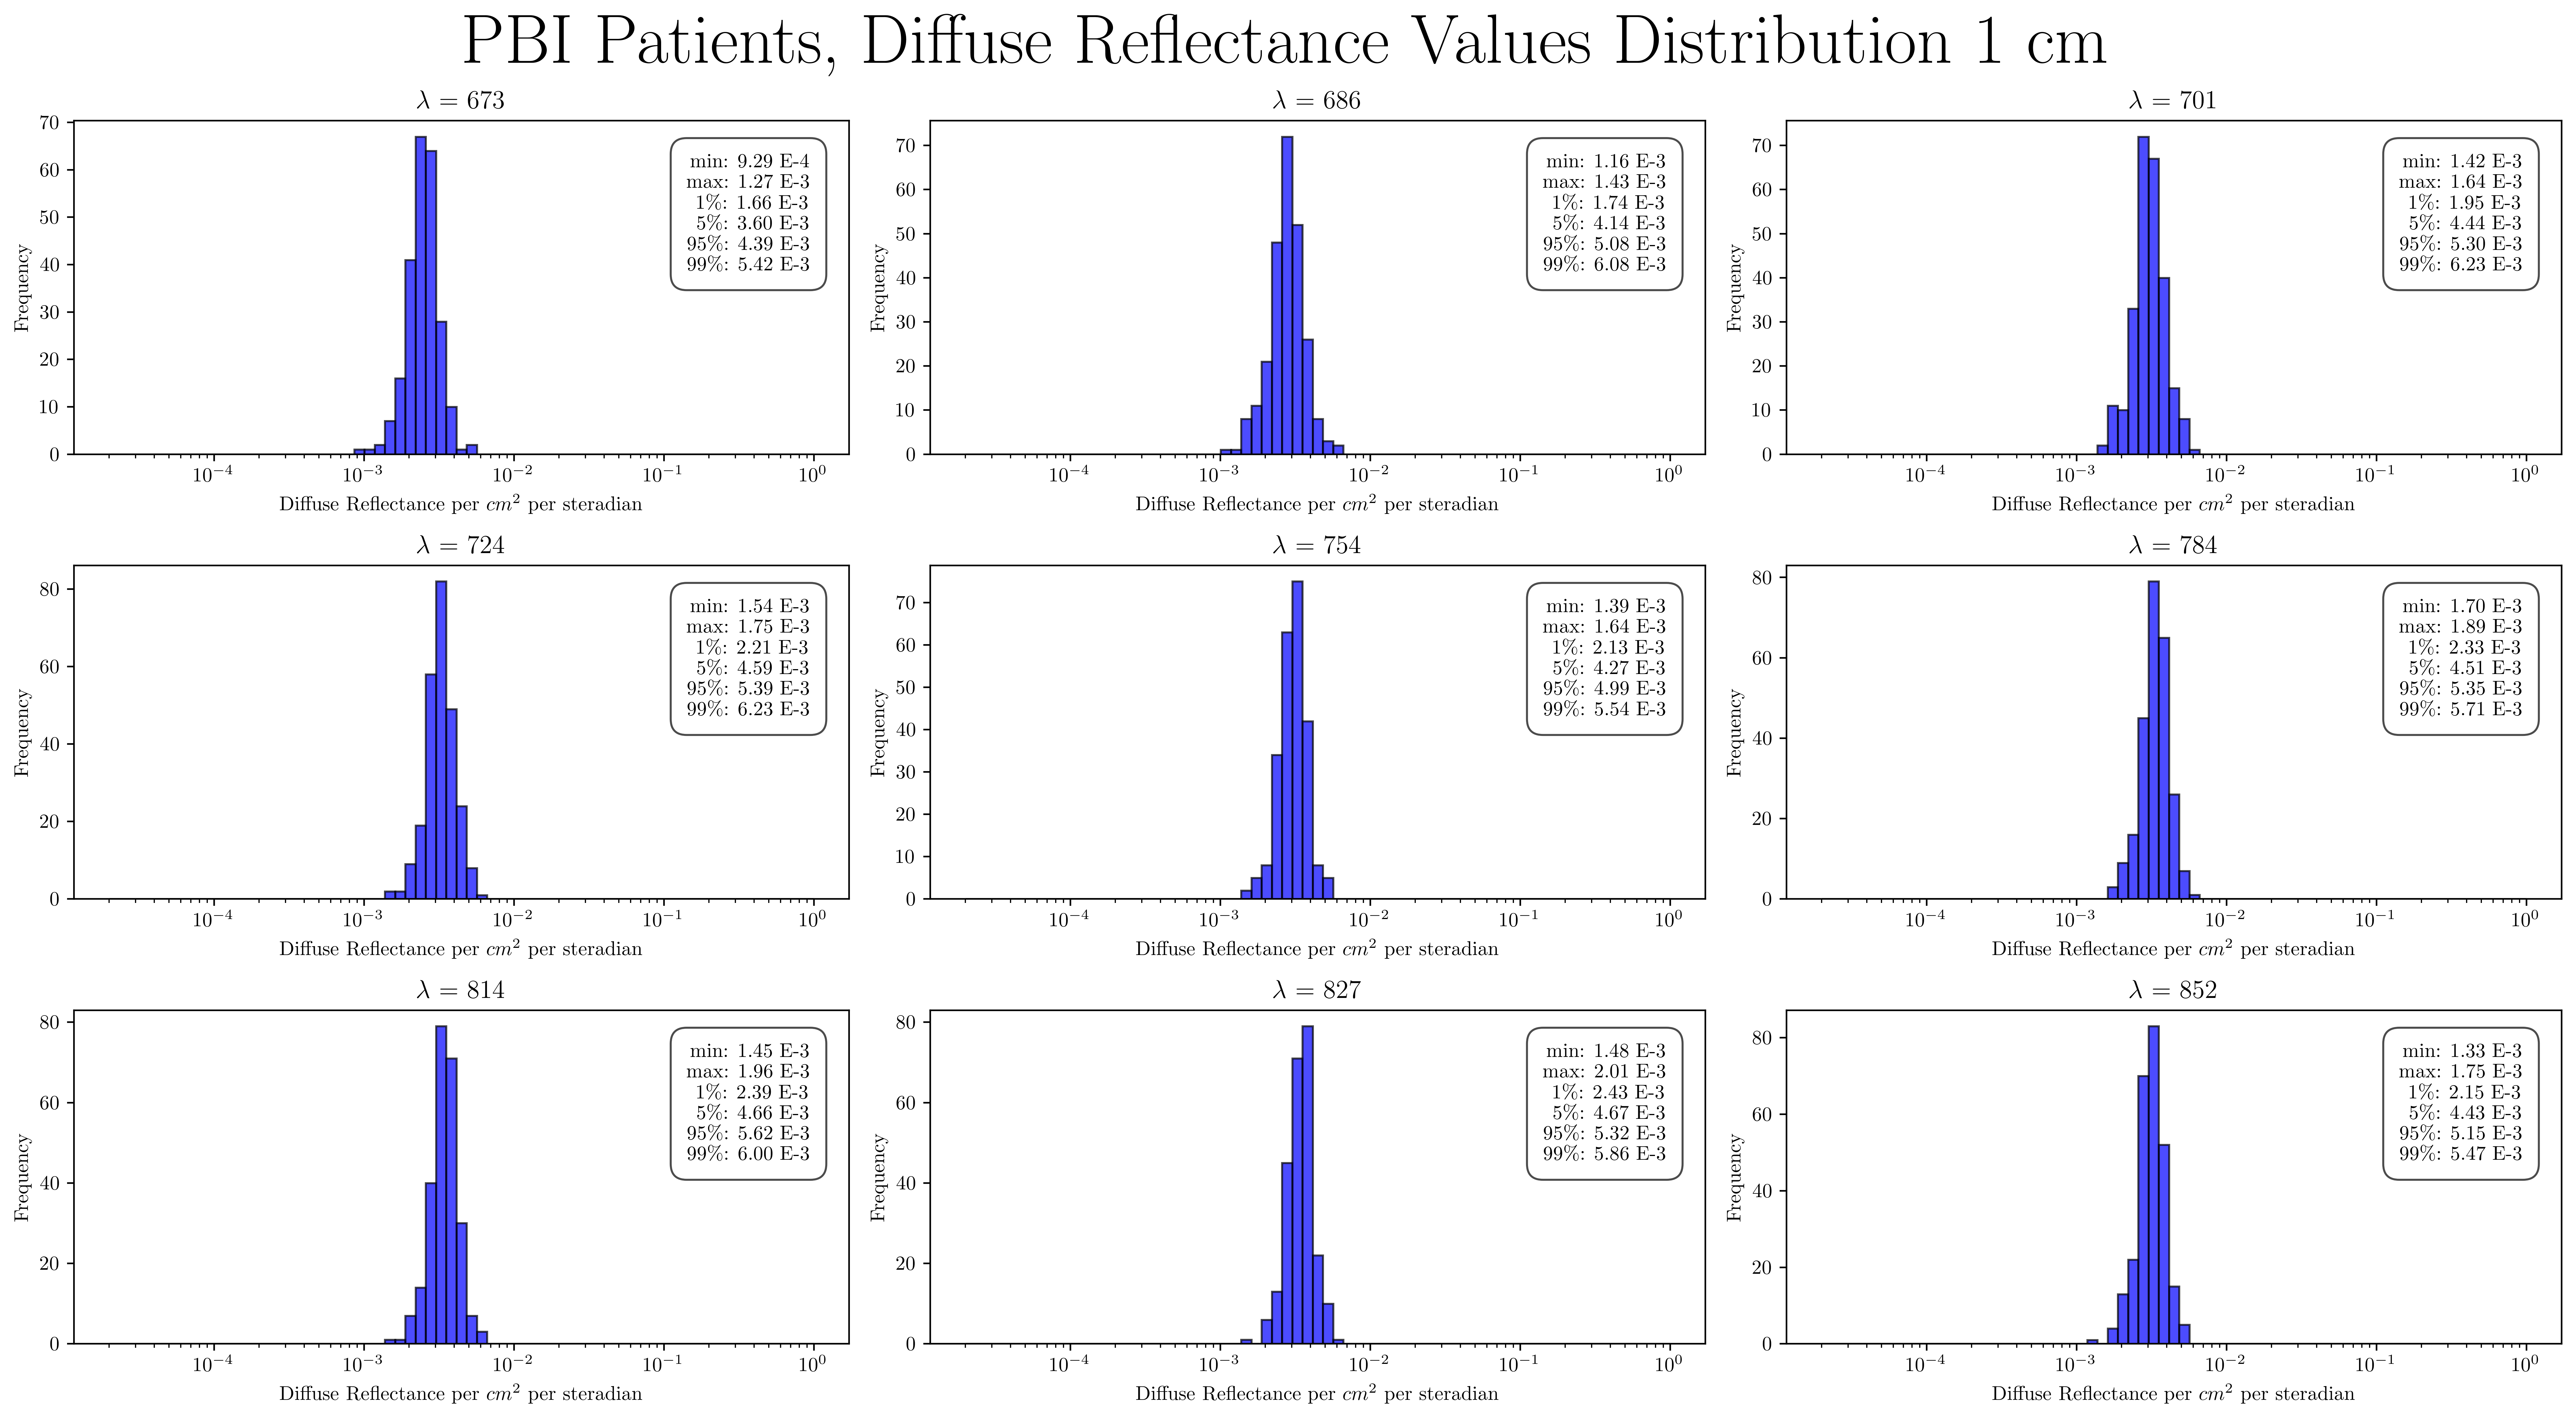

In [22]:

patients = 'PBI'
distance = str(rho_distance[0])+'_cm'
dr_dict_p = diff_ref_dict_d[patients][distance]
stat_dict_dr_p = stat_dict_dr_d[patients][distance]
log_bins = np.logspace(np.log10(0.00002), np.log10(1), 70)

fig, axs = plt.subplots(3, 3, figsize=(18, 10), dpi=500)
axs = axs.flatten()

for wv in range(len(wavelengths)):
    stat_array = stat_dict_dr_p[wavelengths[wv]]
    axs[wv].hist(dr_dict_p[wavelengths[wv]], bins=log_bins, color='blue', edgecolor='black', alpha=0.7)
    axs[wv].set_xlabel(fr'Diffuse Reflectance per $cm^2$ per steradian')
    axs[wv].set_xscale('log')
    axs[wv].set_ylabel(r"Frequency")
    axs[wv].set_title(fr"$\lambda$ =  {wavelengths[wv]}",fontsize = 13)

    # Add personalized text in the upper right corner
    text = f"min: {stat_array[0]}\nmax: {stat_array[1]}\n1\%: {stat_array[2]}\n5\%: {stat_array[3]}\n95\%: {stat_array[4]}\n99\%: {stat_array[5]}"
    axs[wv].text(0.95, 0.9, text, transform=axs[wv].transAxes, fontsize=10,
                verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.7, edgecolor='black', boxstyle='round,pad=0.8'))


fig.suptitle(fr"{patients} Patients, Diffuse Reflectance Values Distribution " + distance[0]+ " cm", fontsize=35, fontweight='bold')

plt.tight_layout()
plt.savefig('Diffuse_Reflectance_Histogram_'+str(patients)+'_'+str(distance)+'_cm_.jpg', dpi=500)
# plt.show()


In [23]:
# Making a dictionary of the stats of all populations and wavelengths, one dictionary with the actual values and the other in string type
def dict_stats_all_pops(wavelengths_array, final_dict_all_pops, stat_dict_diff_ref_v,stat_dict_diff_ref_string, µs_dict_stats_val, µs_dict_stats_s):
    
    categories = ['Min_DR','1%_DR','5%_DR','95%_DR','99%_DR','Max_DR']
    categories = categories[::-1]
    stats_df_dict_by_d = {};
    whole_data = {}; whole_data['values'] = pd.DataFrame(); whole_data['format_string'] = pd.DataFrame();

    dictionaries_of_stats = [stat_dict_diff_ref_v,stat_dict_diff_ref_string]
    dictionaries_of_stats_µs = [µs_dict_stats_val,µs_dict_stats_s]
    individual_dfs_columns = list(final_dict_all_pops.keys())
    for p in range (0,len(individual_dfs_columns)): 
        individual_dfs_columns.insert((3*p) +1 ,'µa'); individual_dfs_columns.insert((3*p) + 2 ,'µsp')

    individual_dfs_columns.insert(0,'Quantiles')

    for d in rho_distance: 
        df_dict_s_v = {}
        stats_df_dict_by_w = {}
        for i in range (0,2):
            whole_data_wl = pd.DataFrame()
            for cchu_wavl in wavelengths_array: 
                data_df = np.empty((0,25))
                temp_dict_cat_val = {}

                for n,cat in enumerate(categories): 
                    temp_dict_cat_val[cat] = []
                    #Adding each population stat for each category Min_Dr 1%_DR 5%_Dr ...
                    for popltns in final_dict_all_pops.keys(): 
                        temp_dict_cat_val[cat] = np.append(temp_dict_cat_val[cat],dictionaries_of_stats[i][popltns][str(d)+'_cm'][cchu_wavl][-n - 1])
                        #Adding the µs at the end
                        for h in range(0,2): 
                            #print(dictionaries_of_stats_µs[i][popltns][str(d)+'_cm'][cchu_wavl][0][h])
                            temp_dict_cat_val[cat] = np.append(temp_dict_cat_val[cat],dictionaries_of_stats_µs[i][popltns][str(d)+'_cm'][cchu_wavl][-n -1][h])
                    # Inserting the categoery Min_Dr 1%_DR 5%_Dr ...
                    data_df = np.append(data_df, [np.insert(np.array(temp_dict_cat_val[cat],dtype = object),0,cat)], axis = 0)
                    

                # df
                stats_df_dict_by_w[cchu_wavl] = pd.DataFrame(data_df, columns=individual_dfs_columns)
                extra_rows_dict_ = pd.DataFrame({'wl (nm)': [cchu_wavl]*6, 'dis (cm)':[d]*6})
                whole_data_wl = pd.concat([whole_data_wl, pd.concat([stats_df_dict_by_w[cchu_wavl],extra_rows_dict_],axis = 1)],axis = 0)
                

            if i ==0:
                df_dict_s_v['values'] = stats_df_dict_by_w
                whole_data['values'] = pd.concat([whole_data['values'],whole_data_wl],axis = 0)

            else: 
                df_dict_s_v['format_string'] = stats_df_dict_by_w
                whole_data['format_string'] = pd.concat([whole_data['format_string'],whole_data_wl],axis = 0)


        stats_df_dict_by_d[str(d)+'_cm'] = df_dict_s_v


    return stats_df_dict_by_d, whole_data
            

In [27]:
final_dict_df, whole_data_df = dict_stats_all_pops(cchu_wavelengths, final_dict_all_populations, stat_dict_dr_f_v,stat_dict_dr_f, µs_dict_stats_v, µs_dict_stats)
final_dict_df_ac, whole_data_df_ac = dict_stats_all_pops(cchu_wavelengths, final_dict_all_populations, stat_dict_dr_f_v_ac,stat_dict_dr_f_ac, µs_dict_stats_v_ac, µs_dict_stats_ac)
final_dict_df_mod, whole_data_df_mod = dict_stats_all_pops(cchu_wavelengths, final_dict_all_populations, stat_dict_dr_f_v_mod,stat_dict_dr_f_mod, µs_dict_stats_v_mod, µs_dict_stats_mod)

# Passing the dataframes to a csv file
whole_data_df['values'].to_csv('CSV_Files/Stats_Populations/All_populations_with_µ_float.csv',index=False)
whole_data_df['format_string'].to_csv('CSV_Files/Stats_Populations/All_populations_with_µ_string.csv',index=False)

# ac 
whole_data_df_ac['values'].to_csv('CSV_Files/Stats_Populations/All_populations_with_µ_float_ac.csv',index=False)
whole_data_df_ac['format_string'].to_csv('CSV_Files/Stats_Populations/All_populations_with_µ_string_ac.csv',index=False)

# mod 
whole_data_df_mod['values'].to_csv('CSV_Files/Stats_Populations/All_populations_with_µ_float_mod.csv',index=False)
whole_data_df_mod['format_string'].to_csv('CSV_Files/Stats_Populations/All_populations_with_µ_string_mod.csv',index=False)



,Quantiles,pre,µa,µsp,post,µa,µsp,1 mo,µa,µsp,...,µa,µsp,IVH,µa,µsp,PBI,µa,µsp,wl (nm),dis (cm)
0,Max_DR,0.997771,0.294861,6.3298,0.998175,0.301551,3.732023,0.998306,0.417357,8.844212,...,0.417357,8.844212,0.998116,0.334359,6.093129,0.997119,0.214867,4.586466,673,1.0
1,99%_DR,0.996991,NaN,NaN,0.997407,NaN,NaN,0.997469,NaN,NaN,...,NaN,NaN,0.996763,NaN,NaN,0.996391,NaN,NaN,673,1.0
2,95%_DR,0.996361,NaN,NaN,0.996684,NaN,NaN,0.996875,NaN,NaN,...,NaN,NaN,0.996151,NaN,NaN,0.995413,NaN,NaN,673,1.0
3,5%_DR,0.990671,NaN,NaN,0.991527,NaN,NaN,0.99266,NaN,NaN,...,NaN,NaN,0.990491,NaN,NaN,0.991002,NaN,NaN,673,1.0
4,1%_DR,0.986505,NaN,NaN,0.989255,NaN,NaN,0.990238,NaN,NaN,...,NaN,NaN,0.98983,NaN,NaN,0.987584,NaN,NaN,673,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,99%_DR,0.985569,NaN,NaN,0.98644,NaN,NaN,0.987214,NaN,NaN,...,NaN,NaN,0.986013,NaN,NaN,0.987586,NaN,NaN,827,3.0
2,95%_DR,0.982725,NaN,NaN,0.984336,NaN,NaN,0.984167,NaN,NaN,...,NaN,NaN,0.982896,NaN,NaN,0.982441,NaN,NaN,827,3.0
3,5%_DR,0.96152,NaN,NaN,0.965612,NaN,NaN,0.966124,NaN,NaN,...,NaN,NaN,0.946794,NaN,NaN,0.962413,NaN,NaN,827,3.0
4,1%_DR,0.949572,NaN,NaN,0.959176,NaN,NaN,0.958312,NaN,NaN,...,NaN,NaN,0.939958,NaN,NaN,0.958702,NaN,NaN,827,3.0


### The final dataframes for the quantiles are: final_df_v & final_df_v

# Graphing Quantiles

In [ ]:
populations = ['pre', 'post', '1 mo', '6 mo', '12 mo', 'total', 'IVH','PBI']

for di in rho_distance:

    print(di)

    for wlen in cchu_wavelengths: 
        fig_cols = 2
        fig, axs = plt.subplots(1, fig_cols, figsize=(15, 5), dpi=500)
        axs = axs.flatten()


        indices_categories = [['Max_DR','99%_DR', '95%_DR'],['5%_DR','1%_DR', 'Min_DR']]

        text = f"min: {stat_array[0]}\nmax: {stat_array[1]}\n1\%: {stat_array[2]}\n5\%: {stat_array[3]}\n95\%: {stat_array[4]}\n99\%: {stat_array[5]}"

        indices_categories_p = [['Max','99\%', '95\%'],['5\%','1\%', 'Min']]

        width = 0.15  # width of the bars
        gap = 2  # gap between groups
        colormap = plt.cm.tab20b

        for c in range(0,fig_cols): 
            data_frame_p = stats_df_dict_by_d_v[str(di)+'_cm'][wlen][stats_df_dict_by_d_v[str(di)+'_cm'][wlen]['Quantiles'].isin(indices_categories[c])]
            groups = len(data_frame_p.columns) - len(populations)*2
            indices = np.arange(len(data_frame_p.index)) * (width * (groups + gap))
            for i, (column, color) in enumerate(zip(populations, colormap(np.linspace(0, 1,groups)))):
                axs[c].bar(indices + i * width, data_frame_p[column], width=width, label=column, color=color)

            axs[c].legend(title='Populations', bbox_to_anchor=(0.80, 0.99), loc='upper left')
            axs[c].set_xlabel('Percentile groups')
            axs[c].set_ylabel('Diffuse Reflectance per Str per $cm^2$')
            axs[c].set_title(fr"Disffuse Reflectance Statistics $\lambda$ =  {wlen} nm, distance = {di} cm")
            axs[c].set_xticks(indices + (width * groups) / 2)
            axs[c].set_xticklabels(indices_categories_p[c])

        plt.tight_layout()
        plt.savefig(fr'Histogram_and_Plots/Stats_Populations_Histograms/{str(di)}_cm/Populations_DR_Histogram_l_'+str(wlen)+'_d_'+str(di)+'_cm.jpg', dpi=500)
        plt.close(plt.gcf())


1
1.5
2
2.5
3


# Dynamic Ranges

In [ ]:
#Dynamic Ranges
d_dynamic_range_dict = {}
indices_dynamic = ['Max / Min', '99% / 1%', '95% / 5%']
full_data_dyn_range_m = np.empty((0,11));
cols_df = list(µs_dict_stats.keys())
cols_df.insert(0,'Quantiles')

full_d_dynran_matrix = np.empty((0,3))
for d in rho_distance:
    wl_dynamic_range_dict = {}
    for wl in cchu_wavelengths:
        population_matrix_values = np.empty((0,3))
        
        for population in list(µs_dict_stats.keys()): 
            array_stat = stats_df_dict_by_d_v[str(d)+'_cm'][wl][population].to_numpy()
            dynamic_r_1 = round(array_stat[0]/array_stat[5],3)
            dynamic_r_2 = round(array_stat[1]/array_stat[4],3)
            dynamic_r_3 = round(array_stat[2]/array_stat[3],3)
            population_matrix_values = np.array(np.append(population_matrix_values, [np.asarray([dynamic_r_1,dynamic_r_2,dynamic_r_3])], axis=0),dtype=object)
        

        full_d_dynran_matrix = population_matrix_values.copy()
        population_matrix_values = np.insert(population_matrix_values,0,[indices_dynamic[0],indices_dynamic[1],indices_dynamic[2]],axis=0)
        full_d_dynran_matrix = np.append(full_d_dynran_matrix, [np.asarray([wl,wl,wl])], axis=0);
        full_d_dynran_matrix = np.append(full_d_dynran_matrix, [np.asarray([str(d)+'_cm',str(d)+'_cm',str(d)+'_cm'])], axis=0);
        full_d_dynran_matrix = np.insert(full_d_dynran_matrix, 0, [np.asarray([indices_dynamic[0],indices_dynamic[1],indices_dynamic[2]])], axis=0)
        full_data_dyn_range_m = np.append(full_data_dyn_range_m, np.transpose(full_d_dynran_matrix), axis = 0)
        
        wl_dynamic_range_dict[wl] = pd.DataFrame(np.transpose(population_matrix_values), columns = cols_df)

    d_dynamic_range_dict[str(d)+'_cm'] = wl_dynamic_range_dict

categories_dyn = cols_df
categories_dyn.extend(['wavelength (nm)','distance (cm)']);
full_data_dynrange_df = pd.DataFrame(full_data_dyn_range_m,columns = categories_dyn)

# Passing the dynamic range dataframes to csv
full_data_dynrange_df.to_csv('CSV_Files/Dynamic_Range/dynamic_range_df.csv',index = False)



In [ ]:
full_data_dynrange_df[full_data_dynrange_df['distance (cm)']=='3_cm']


,Quantiles,pre,post,1 mo,6 mo,12 mo,total,IVH,PBI,wavelength (nm),distance (cm)
96,Max / Min,579.931,2459.682,1779.155,6338.685,1938.525,13626.186,1333.266,2058.712,673,3_cm
97,99% / 1%,118.992,554.049,264.661,357.127,528.744,819.991,143.703,68.835,673,3_cm
98,95% / 5%,31.029,60.83,58.656,40.305,70.635,84.752,56.261,12.498,673,3_cm
99,Max / Min,341.29,1140.411,1010.28,2908.222,1148.231,5241.531,643.467,1016.326,686,3_cm
100,99% / 1%,85.285,302.387,182.616,239.847,373.705,486.58,147.878,87.136,686,3_cm
101,95% / 5%,25.664,43.814,46.207,30.172,46.498,63.409,57.832,15.766,686,3_cm
102,Max / Min,215.026,574.564,555.112,1478.051,657.276,2548.409,387.964,607.63,701,3_cm
103,99% / 1%,60.465,169.19,103.907,91.164,179.731,230.172,115.79,82.798,701,3_cm
104,95% / 5%,21.279,31.478,33.653,21.595,34.334,44.288,48.094,14.988,701,3_cm
105,Max / Min,161.337,484.866,407.881,854.114,361.602,1290.972,260.507,498.435,724,3_cm


In [ ]:
# Write csv's and excel files by distance


for d in rho_distance: 
        for w in cchu_wavelengths: 
                with pd.ExcelWriter(fr'Excel_Files/{csv_file_paths[0]}/{d}_cm/{w}_nm_v.xlsx', engine='xlsxwriter') as writer:
                       stats_df_dict_by_d_v[str(d)+'_cm'][w].to_excel(writer)
                with pd.ExcelWriter(fr'Excel_Files/{csv_file_paths[0]}/{d}_cm/{w}_nm_s.xlsx', engine='xlsxwriter') as writer:
                       stats_df_dict_by_d_s[str(d)+'_cm'][w].to_excel(writer)
                with pd.ExcelWriter(fr'Excel_Files/{csv_file_paths[1]}/{d}_cm/{w}_nm.xlsx', engine='xlsxwriter') as writer:
                        d_dynamic_range_dict[str(d)+'_cm'][w].to_excel(writer)

                stats_df_dict_by_d_v[str(d)+'_cm'][w].to_csv(fr'CSV_Files/{csv_file_paths[0]}/{d}_cm/{w}_nm_v.csv',index = False)
                stats_df_dict_by_d_s[str(d)+'_cm'][w].to_csv(fr'CSV_Files/{csv_file_paths[0]}/{d}_cm/{w}_nm_s.csv',index = False)
                d_dynamic_range_dict[str(d)+'_cm'][w].to_csv(fr'CSV_Files/{csv_file_paths[1]}/{d}_cm/{w}_nm.csv',index = False)



## Graphing Dynamic Ranges

1
1.5
2
2.5
3


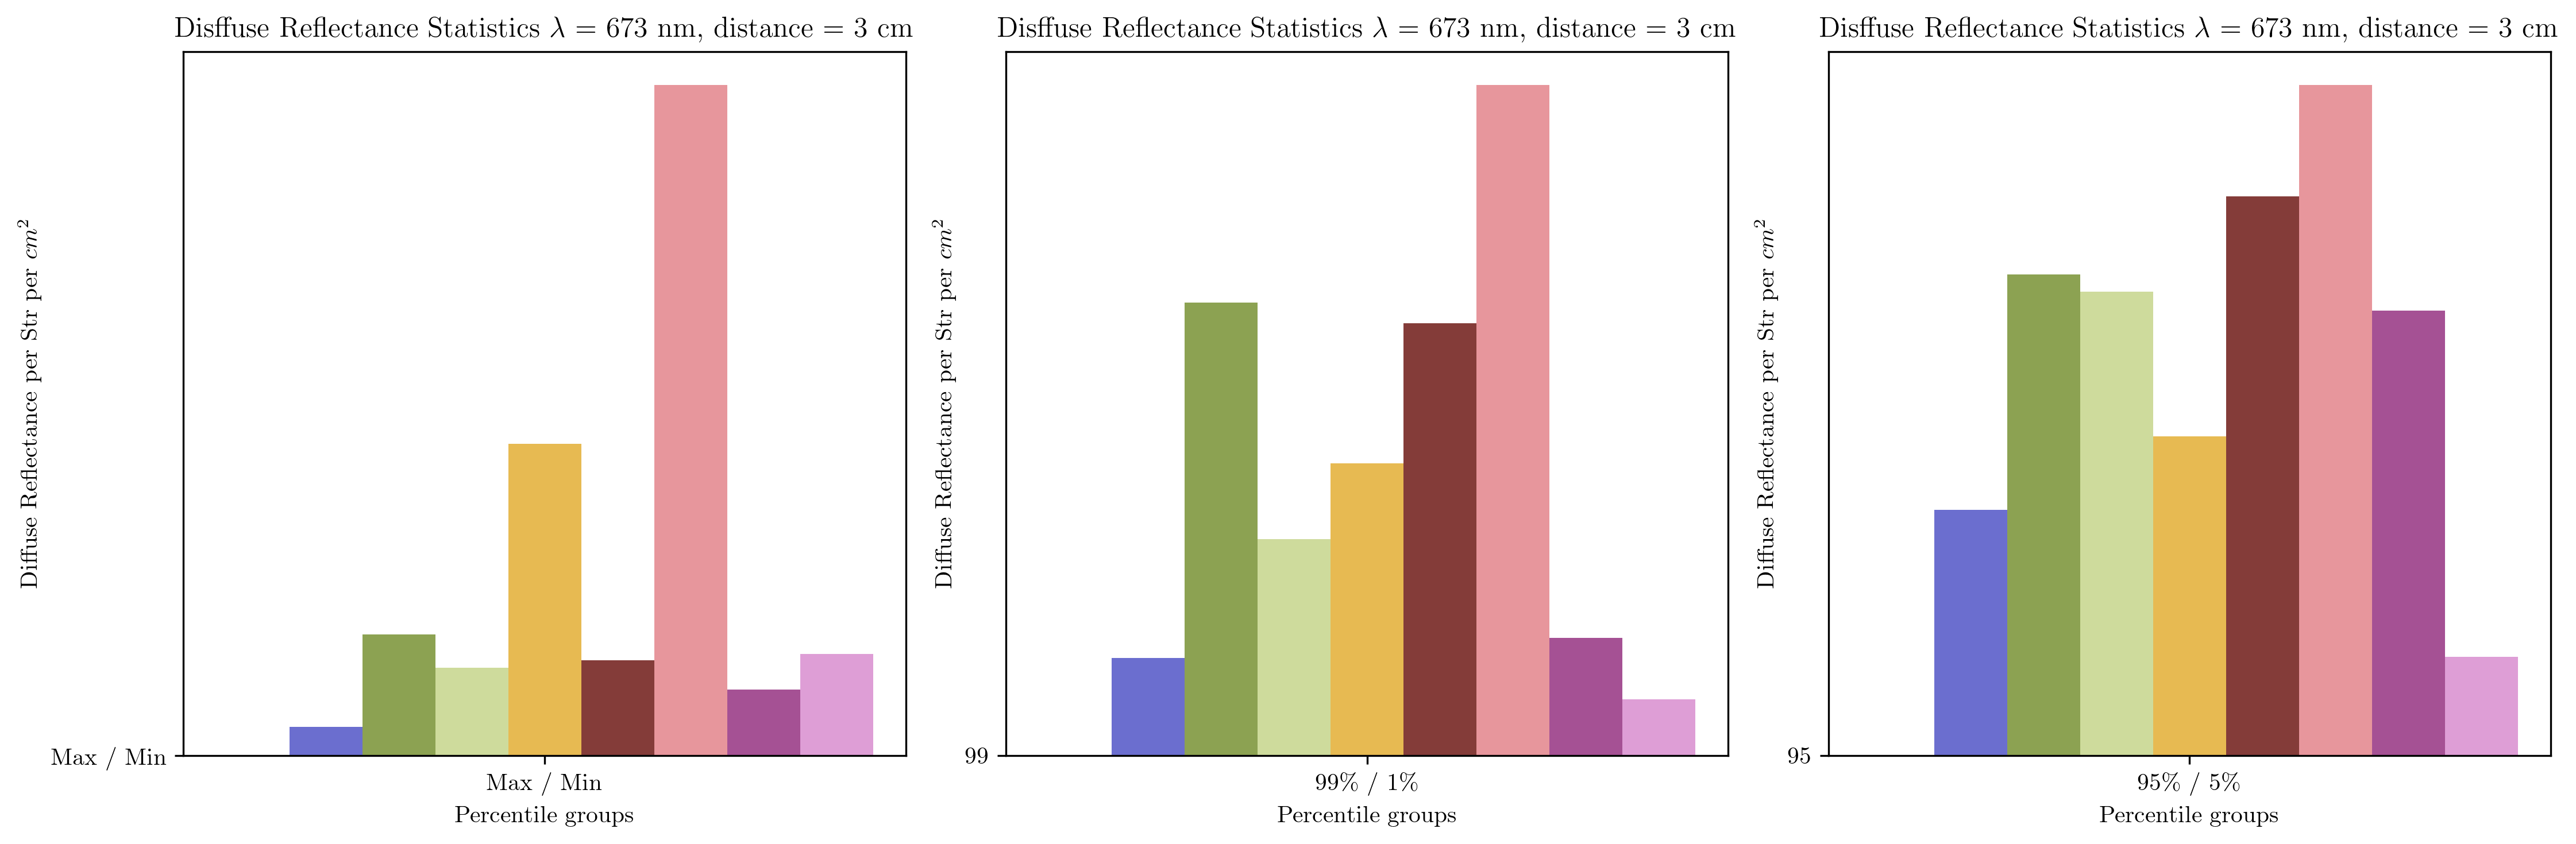

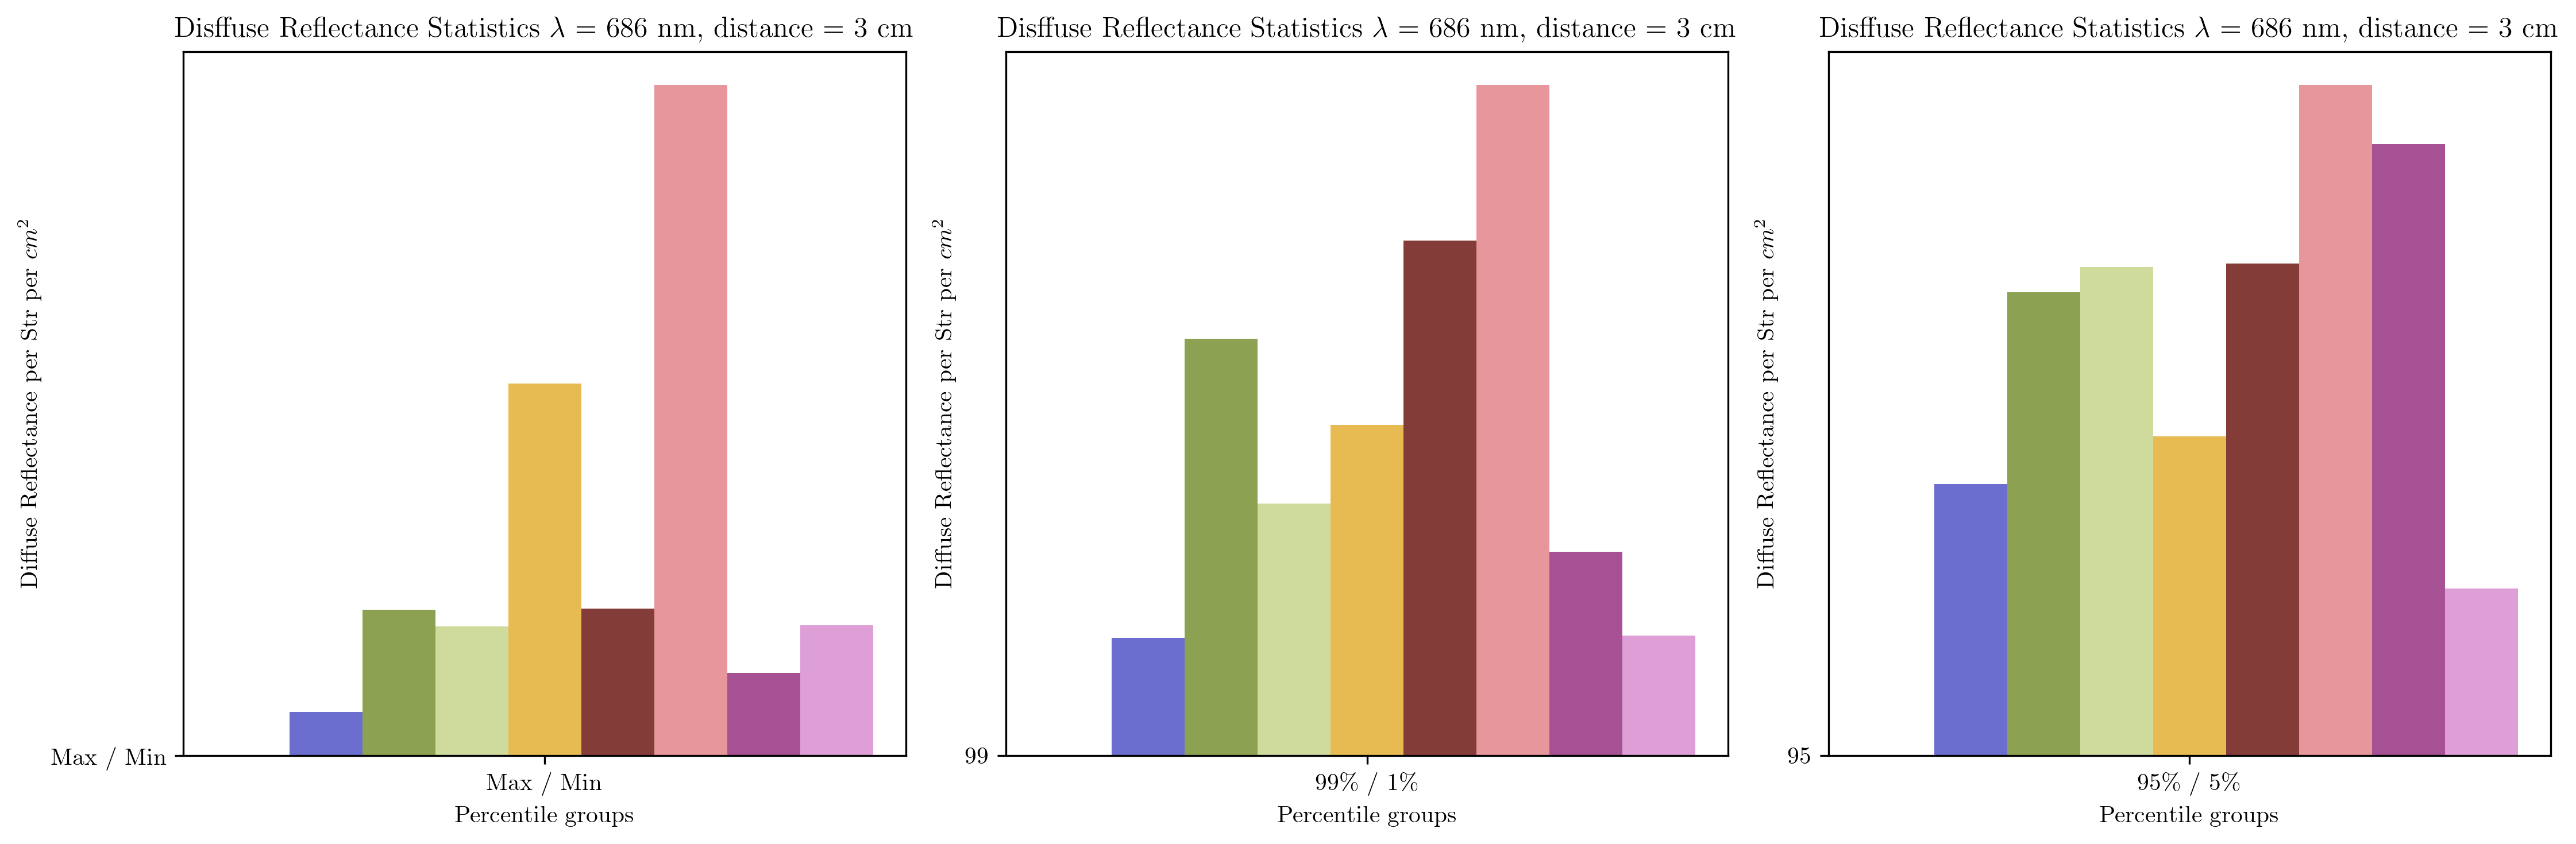

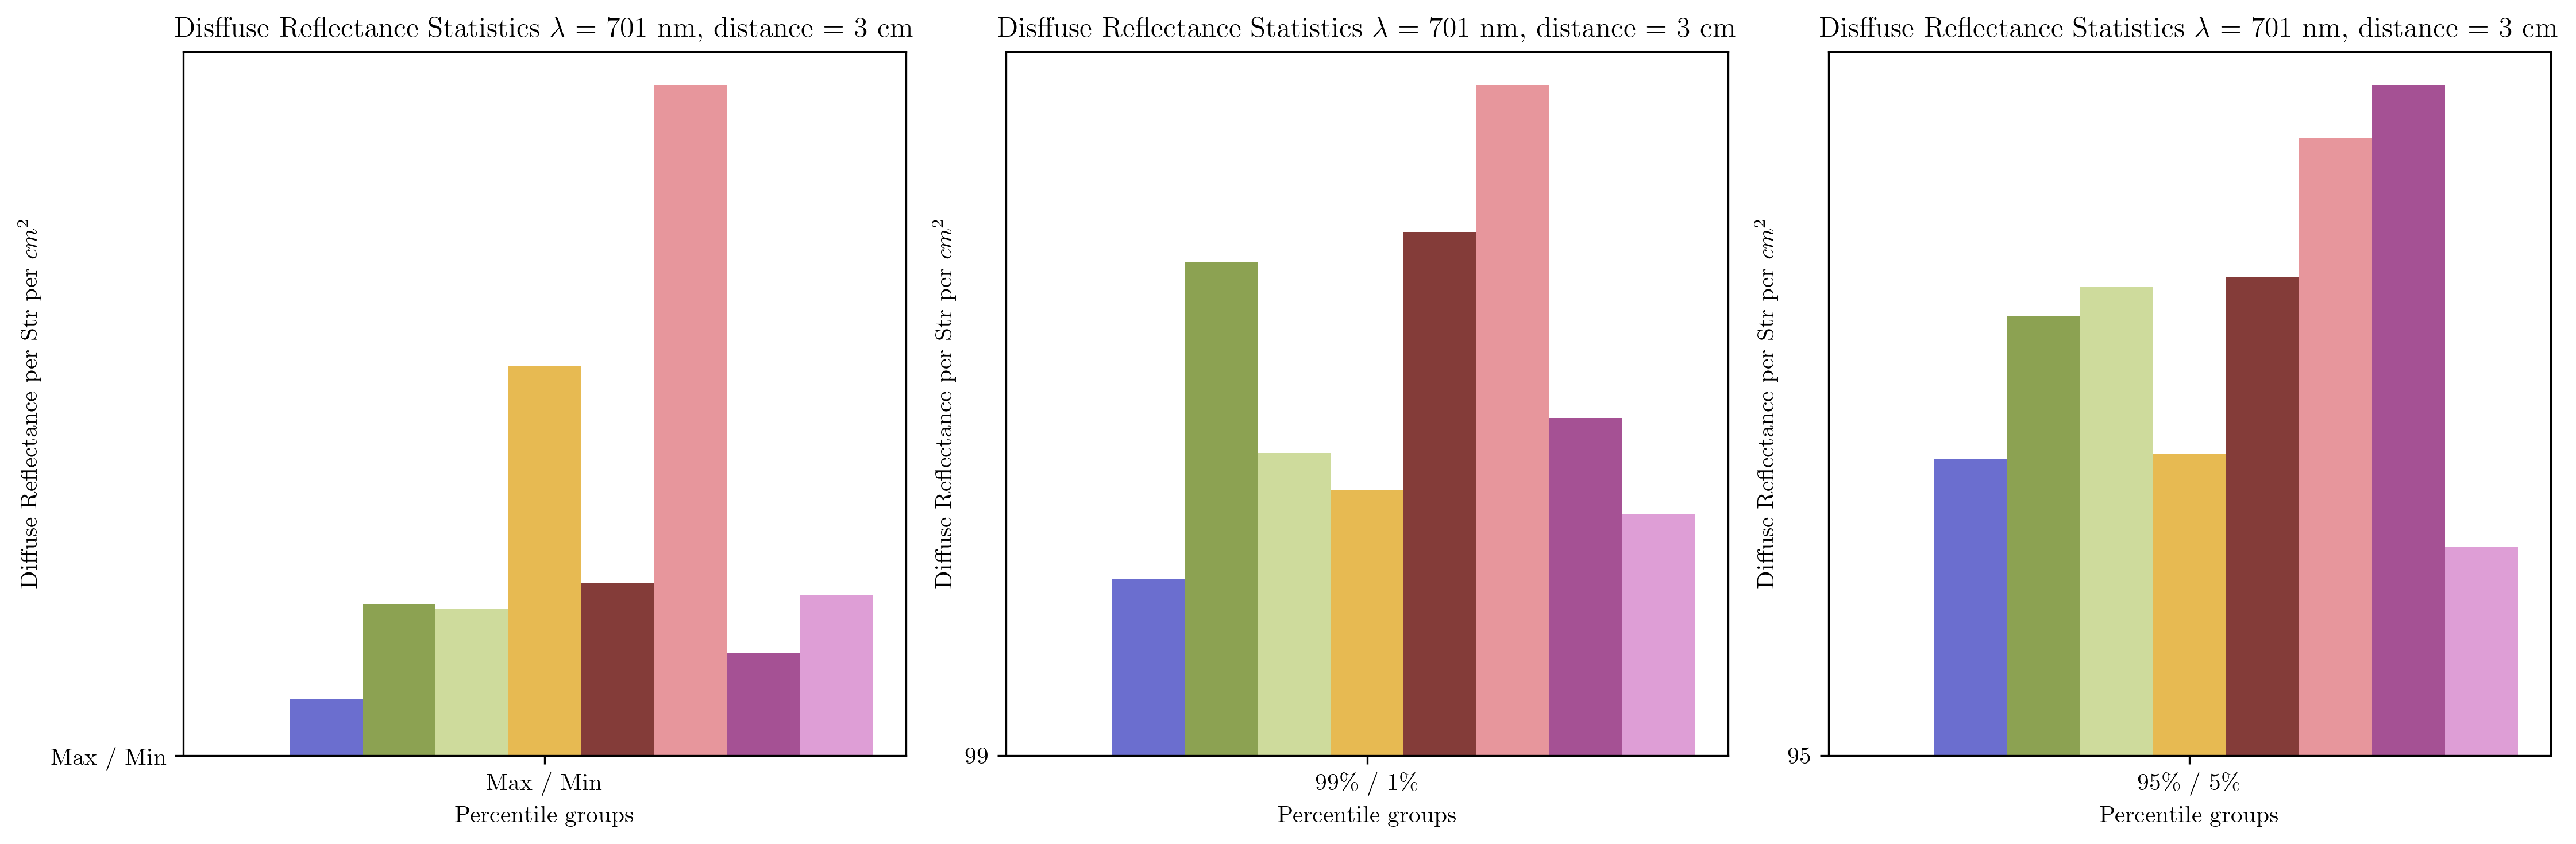

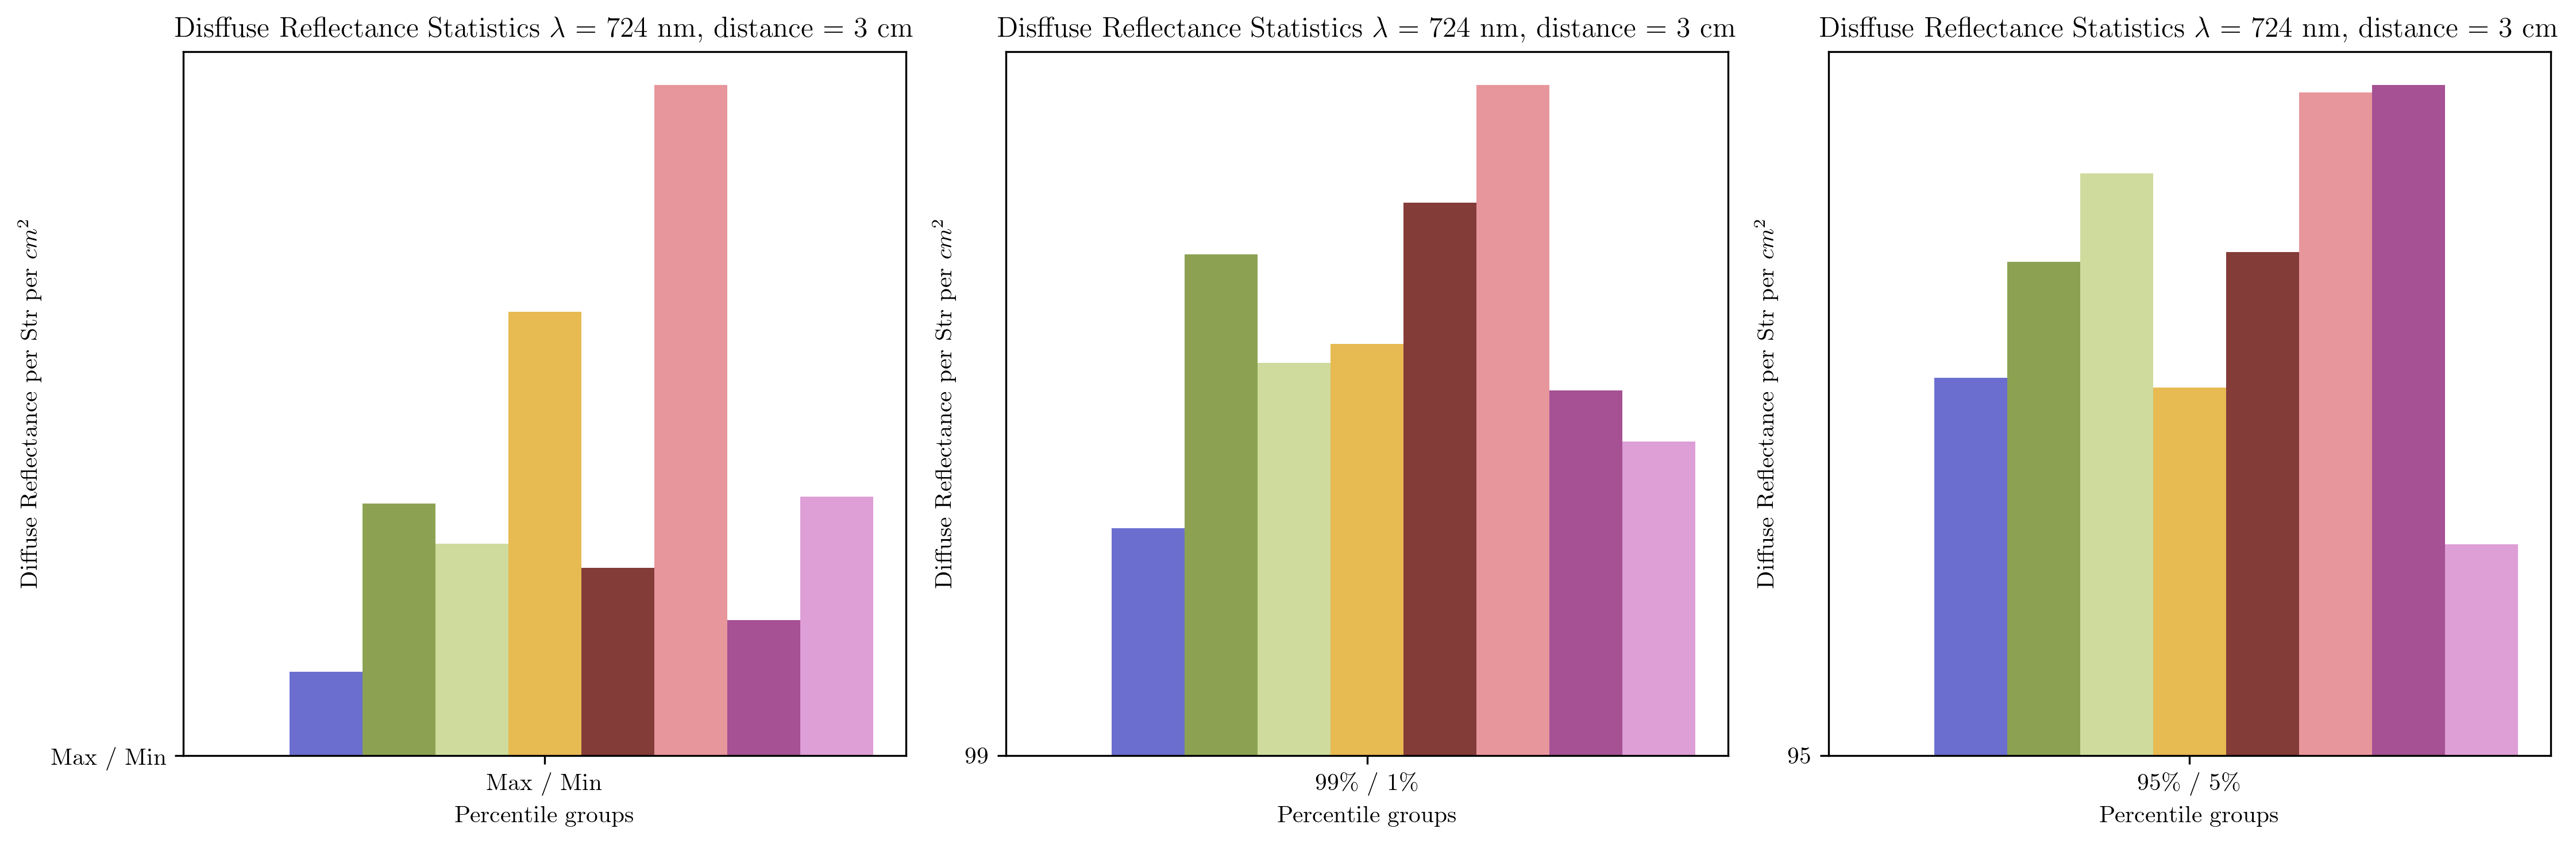

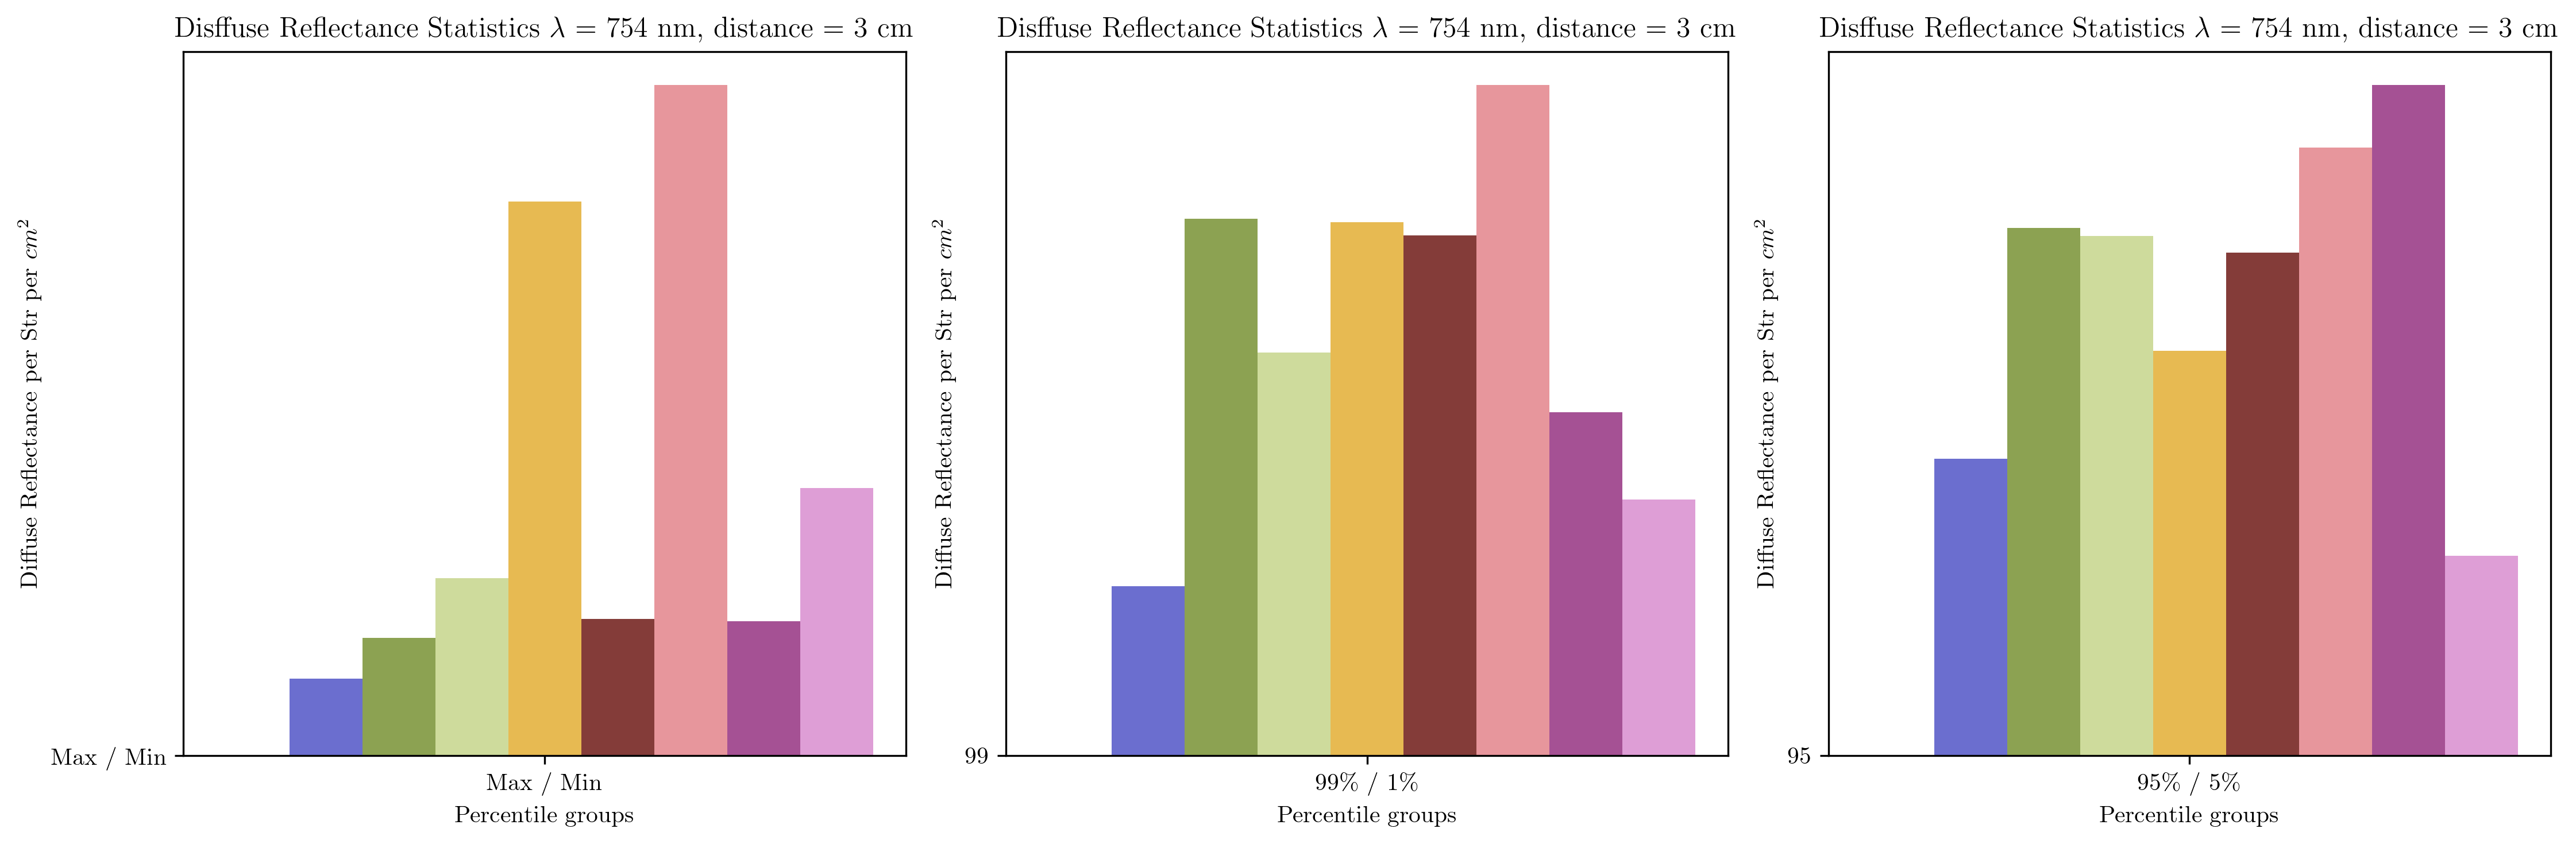

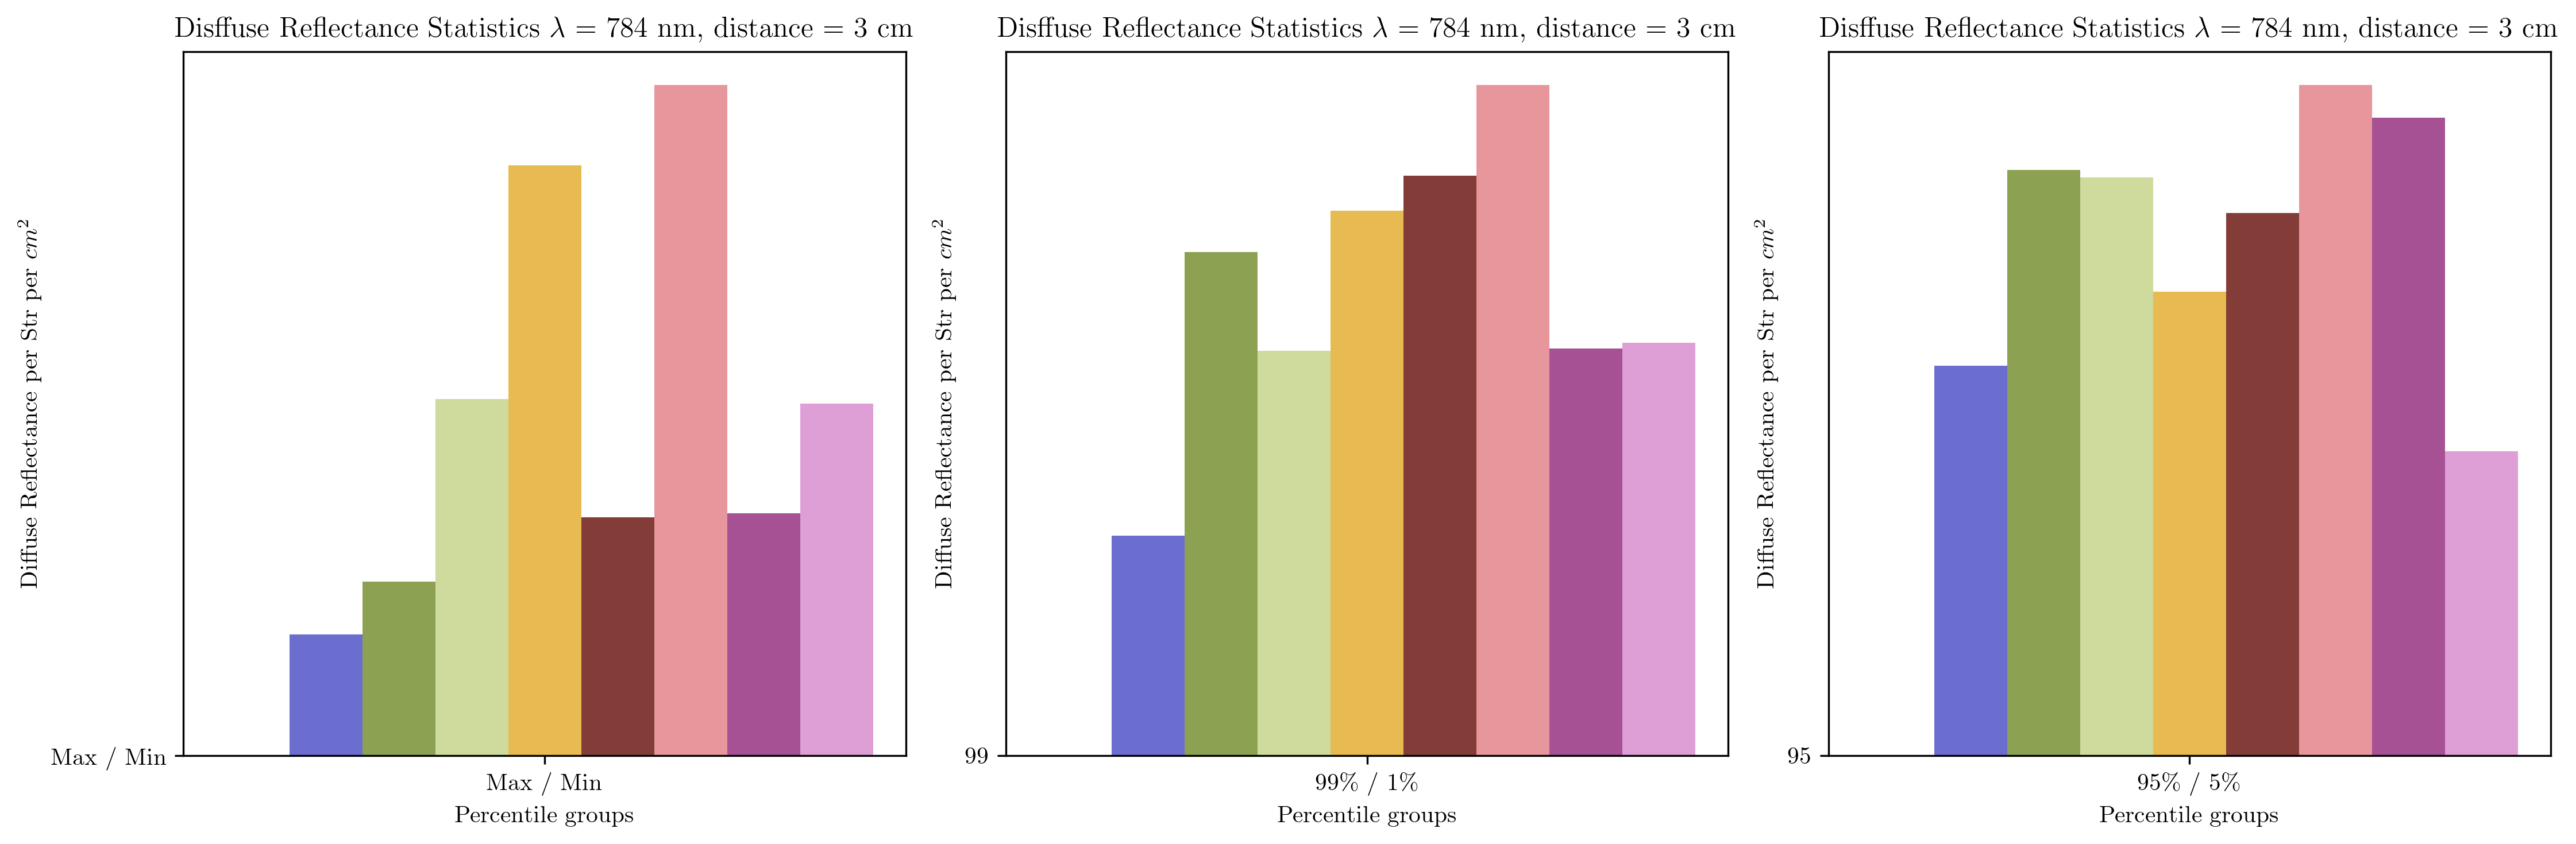

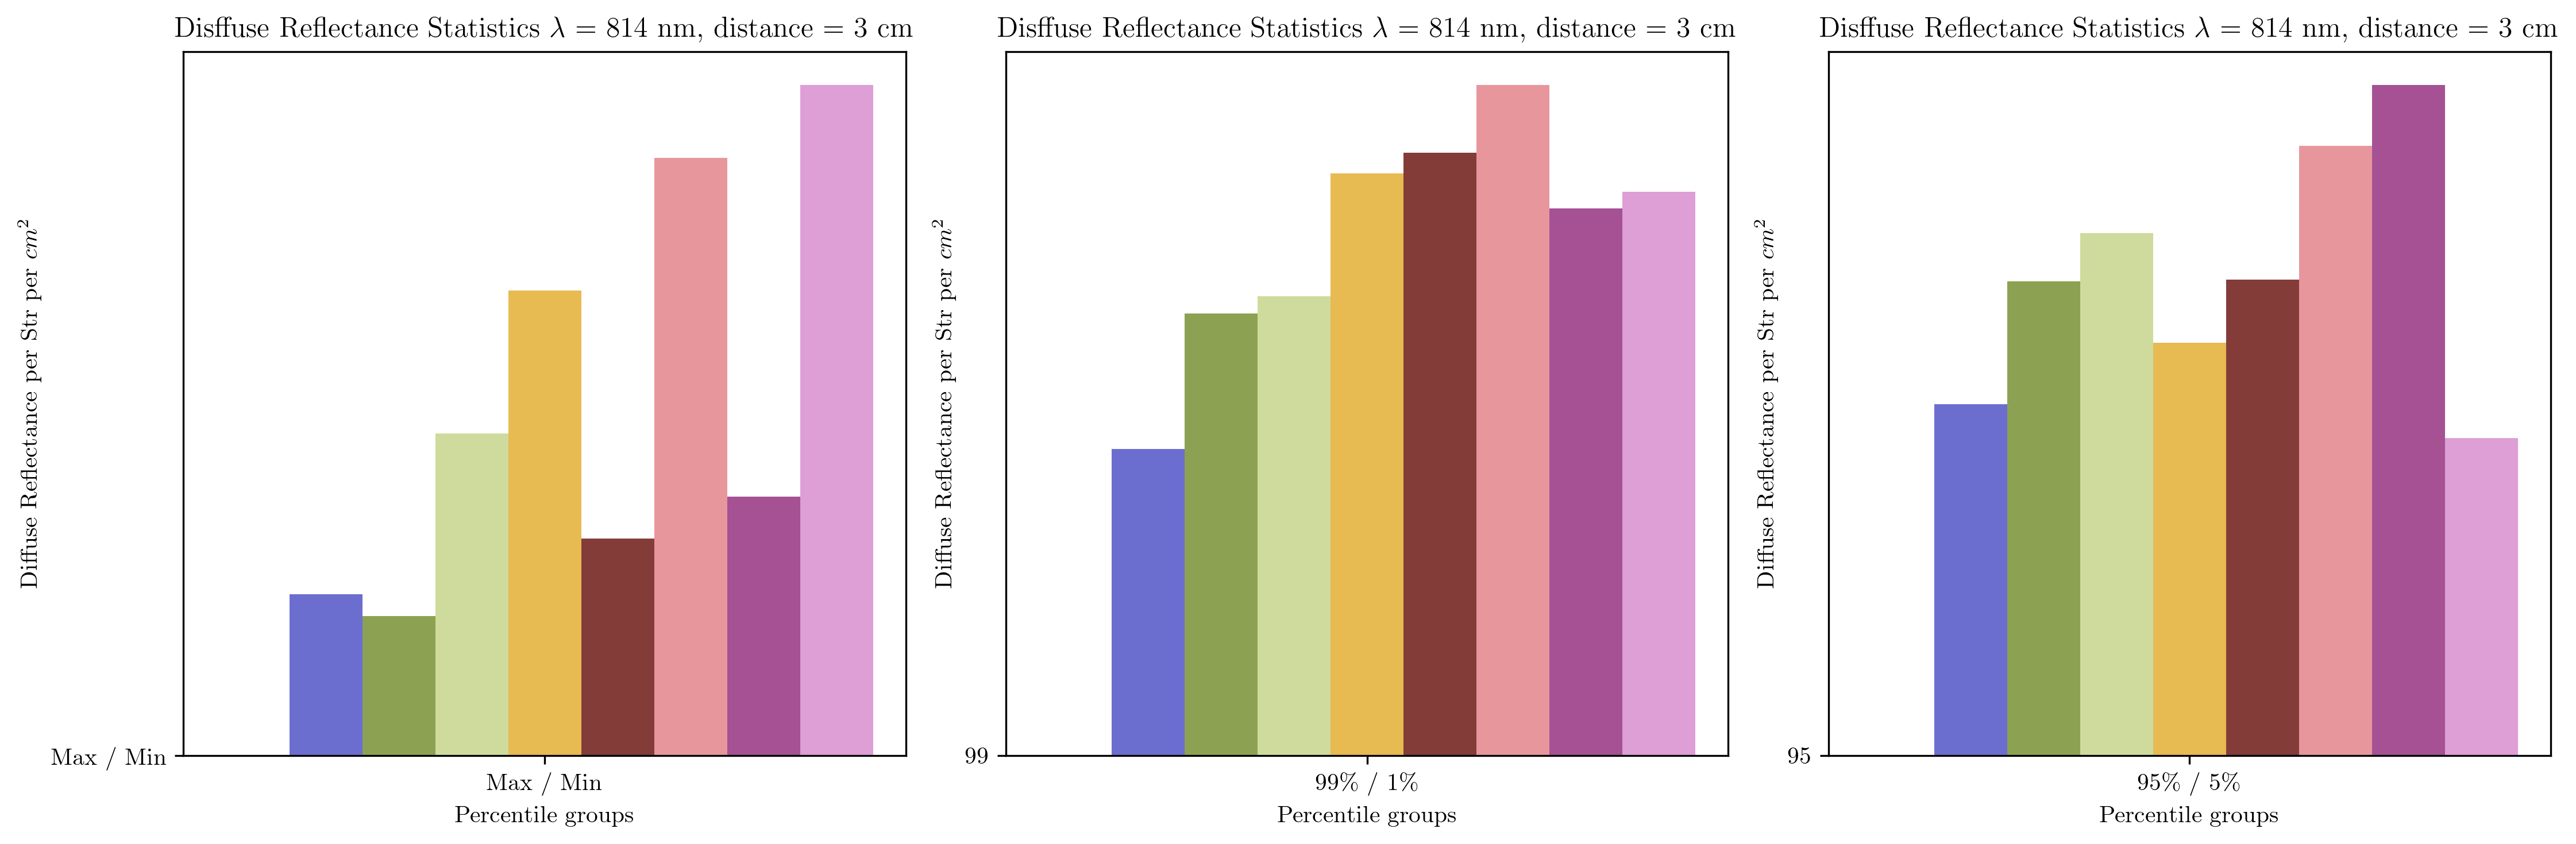

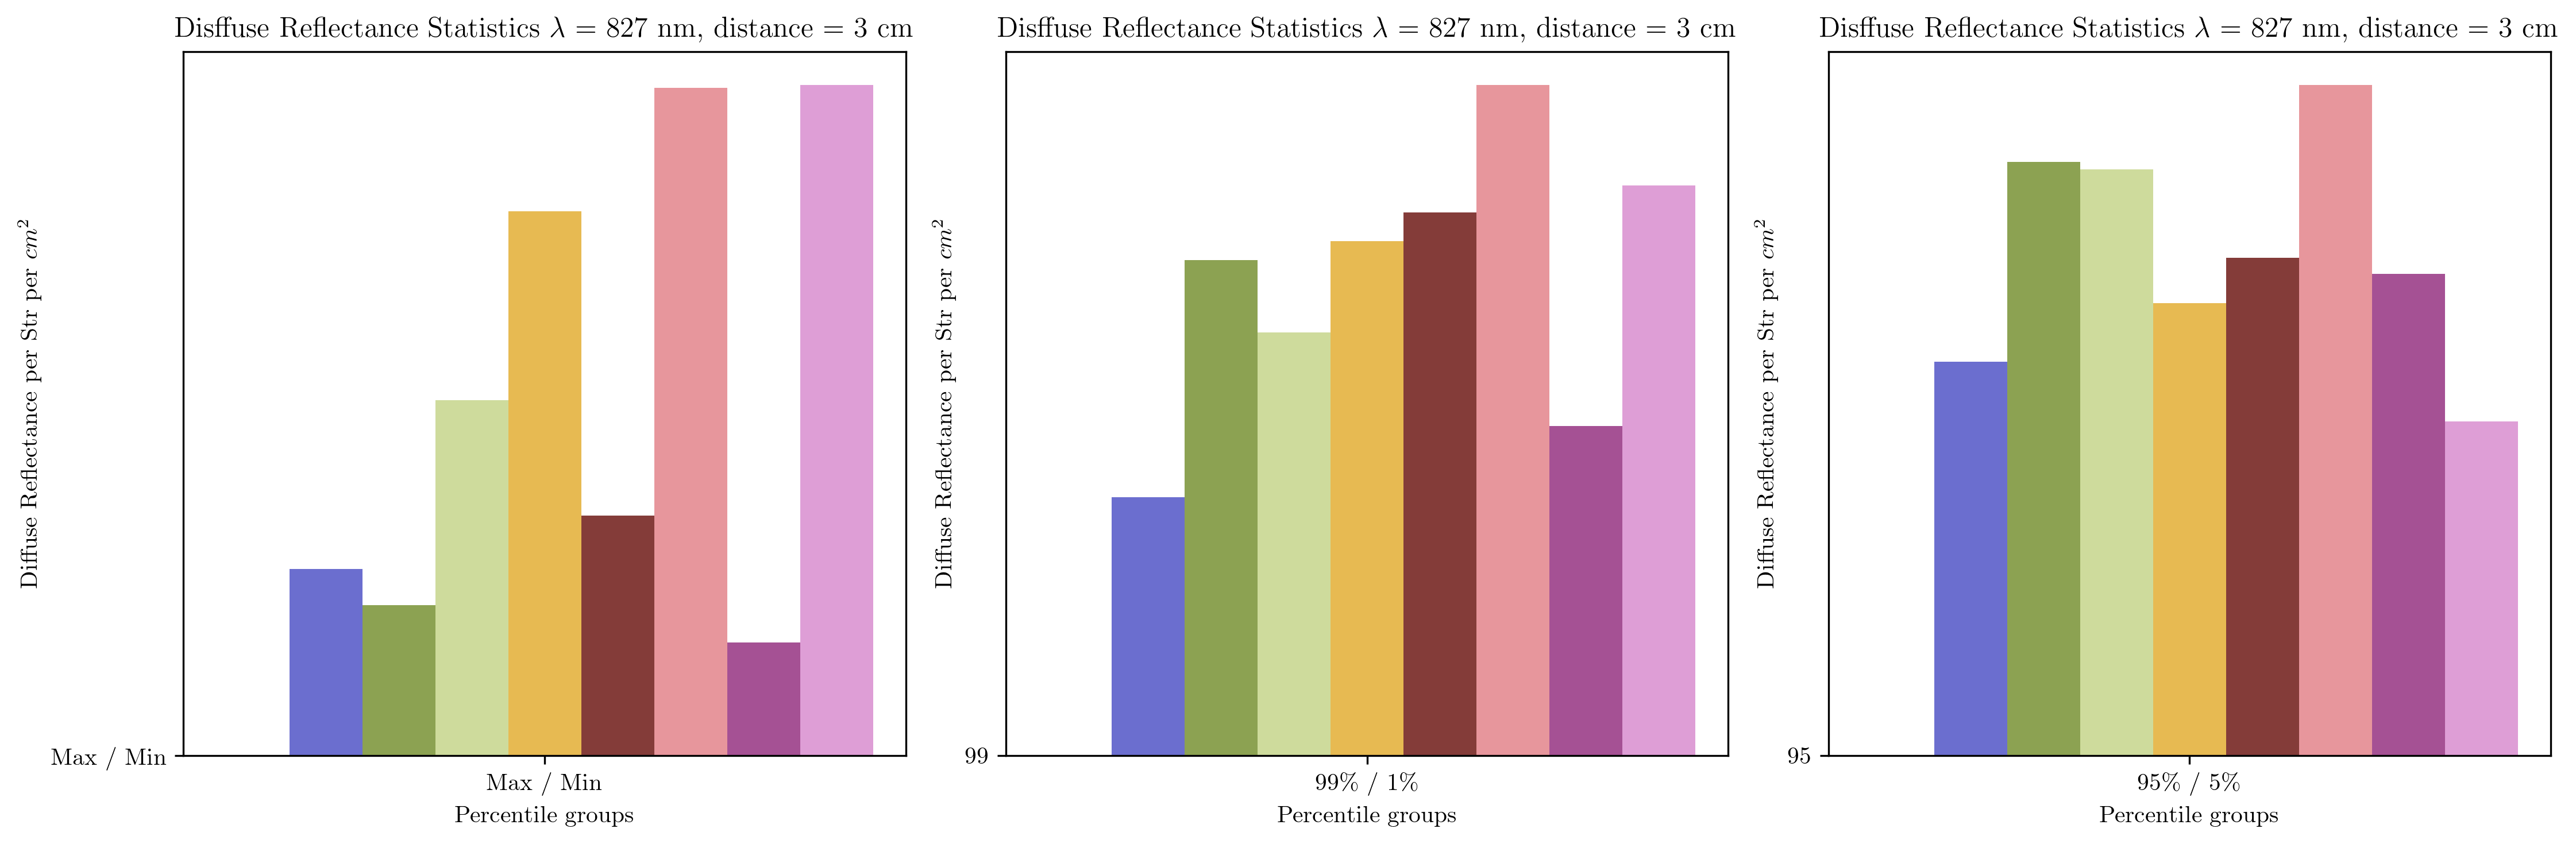

In [ ]:

for d in rho_distance:
    print(d)
    dynamic_indices_cat = [['Max / Min'], ['99% / 1%'],['95% / 5%']]; dynamic_labels = [['Max / Min'], ['99\% / 1\%'],['95\% / 5\%']]
    fig_cols = 3
    for wlen in cchu_wavelengths:  
        fig, ax_d = plt.subplots(1, fig_cols, figsize=(15, 5), dpi=300)
        ax_d = ax_d.flatten()

        text = f"min: {stat_array[0]}\nmax: {stat_array[1]}\n1\%: {stat_array[2]}\n5\%: {stat_array[3]}\n95\%: {stat_array[4]}\n99\%: {stat_array[5]}"

        width = 0.15  # width of the bars
        gap = 2  # gap between groups
        colormap = plt.cm.tab20b


        for c in range(0,fig_cols):
            data_frame_p = d_dynamic_range_dict[str(d)+'_cm'][wlen][d_dynamic_range_dict[str(d)+'_cm'][wlen]['Quantiles'].isin(dynamic_indices_cat[c])]
            #data_frame_p = wl_dynamic_range_dict[wlen]
            groups = len(data_frame_p.columns[0:-1])
            indices = np.arange(len(data_frame_p.index)) * (width * (groups + gap))
            for i, (column, color) in enumerate(zip(data_frame_p.columns, colormap(np.linspace(0, 1, len(data_frame_p.columns))))):
                ax_d[c].bar(indices + i * width, data_frame_p[column], width=width, label=column, color=color)

            #ax_d[c].legend(title='Populations', bbox_to_anchor=(0.85, 0.98), loc='upper left')
            ax_d[c].set_xlabel('Percentile groups')
            ax_d[c].set_ylabel(fr'Diffuse Reflectance per Str per $cm^2$')
            ax_d[c].set_title(fr"Disffuse Reflectance Statistics $\lambda$ =  {wlen} nm, distance = {d} cm")
            ax_d[c].set_xticks(indices + (width * groups) / 2)
            ax_d[c].set_xticklabels(dynamic_labels[c])


        plt.tight_layout()
        plt.savefig(fr'Histogram_and_Plots/Dynamic_Range_Hist/{d}_cm/{wlen}_nm.jpg', dpi=500)
        if d == rho_distance[-1]:
            pass
        else: 
            plt.close(plt.gcf())


In [ ]:
# 1.  Histogram how many Neutral Filters were used, I'll be looking at the cal block
#  - Neutral Density Filters are not well documented 
#  - Information might not have entered properly and if more than one sesion was held only the first session was recorded. 

# 2. 2D Histogram Neutral Density Filter vs Diffuse Reflectance 

## AC Diffuse Reflectance